# Magnetic reconstructions
This notebook is for exploring magnetic tomography reconstructions.

## 1. Imports

In [1]:
import multi_axis as ma
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from scipy import constants                     # For scientific constants
import matplotlib.patches as patches
import copy
from pyevtk.hl import gridToVTK
#import tomopy
%config Completer.use_jedi = False

## 2. Function definitions
- Generate phase data
- Rotate magnetization
- grid to coor
- coor to grid
- rotate vector
- Plot B slice series
- dual axis: phase generation, B generation, xy recon, z recon
- export B to paraview
- CC MAAPE NRMSE metrics with test function

In [2]:
def generate_phase_data(MX,MY,MZ,angles,mesh_params=None,n_pad=500,unpad=False):
    """ Returns phase projections for given M and angles
    in order [x, i_tilt, y] """
    # Initialise parameters
    phase_projs = []
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(MX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    
    # Loop through projection angles
    for i in range(len(angles)):
        ax,ay,az = angles[i]
        #rotate M
        MXr,MYr,MZr = rotate_magnetisation(MX,MY,MZ,ax,ay,az)
        #calculate phase
        phase = ma.calculate_phase_M_2D(MXr,MYr,MZr,mesh_params=mesh_params,n_pad=n_pad,unpad=unpad)
        phase = np.flipud(phase.T)

        phase_projs.append(phase)            
    
    # Prepare projections for reconstruction
    phase_projs = np.transpose(phase_projs,axes=[1,0,2]) # reshape so proj is middle column
        
    return np.array(phase_projs)

def rotate_magnetisation(U,V,W,ax=0,ay=0,az=0):
    """ 
    Takes 3D gridded magnetisation values as input
    and returns them after an intrinsic rotation ax,ay,az 
    about the x,y,z axes (given in degrees) 
    (Uses convention of rotating about z, then y, then x)
    """
    # Rotate the gridded locations of M values
    Ub = ma.rotate_bulk(U,ax,ay,az)
    Vb = ma.rotate_bulk(V,ax,ay,az)
    Wb = ma.rotate_bulk(W,ax,ay,az)
    
    shape = np.shape(Ub)
    
    # Convert gridded values to vectors
    coor_flat = grid_to_coor(Ub,Vb,Wb)
    
    # Rotate vectors
    coor_flat_r = rotate_vector(coor_flat,ax,ay,az)
    
    # Convert vectors back to gridded values
    Ur,Vr,Wr = coor_to_grid(coor_flat_r,shape=shape)
    
    # Set small values to 0
    # (In theory the magnitude of M in each cell should be Ms,
    #  so we can set magnitude lower than this to zero -
    #  typically python rounding errors lead to very small values,
    #  which it is useful to exclude here)
    mag_max = (np.max(U)**2+np.max(V)**2+np.max(W)**2)**0.5
    mag = (Ur**2+Vr**2+Wr**2)**.5
#     for M in [Ur,Vr,Wr]:
#         M[abs(M)<1e-5*mag_max] = 0
#         M[mag<.6*mag_max] = 0
    
    return Ur,Vr,Wr

def grid_to_coor(U,V,W):
    """ Convert gridded 3D data (3,n,n,n) into coordinates (n^3, 3) """
    coor_flat = []
    nx = np.shape(U)[0]
    ny = np.shape(U)[1]
    nz = np.shape(U)[2]
    for ix in range(nx):
        for iy in range(ny):
            for iz in range(nz):
                x = U[ix,iy,iz]
                y = V[ix,iy,iz]
                z = W[ix,iy,iz]
                coor_flat.append([x,y,z])
                
    return coor_flat

def coor_to_grid(coor_flat,shape=None):
    """ Convert coordinates (n^3, 3) into gridded 3D data (3,n,n,n) """
    if shape == None:
        n = int(np.round(np.shape(coor_flat)[0]**(1/3)))
        shape = (n,n,n)
    nx,ny,nz = shape
    
    x = np.take(coor_flat,0,axis=1)
    y = np.take(coor_flat,1,axis=1)
    z = np.take(coor_flat,2,axis=1)
    U = x.reshape((nx,ny,nz))
    V = y.reshape((nx,ny,nz))
    W = z.reshape((nx,ny,nz))

    return U, V, W

def rotate_vector(coor_flat,ax,ay,az):
    """ Rotates vectors by specified angles ax,ay,az 
    about the x,y,z axes (given in degrees) """
    
    # Get rotation matrix
    mrot = ma.rotation_matrix(ax,ay,az)    

    coor_flat_r = np.zeros_like(coor_flat)
    
    # Apply rotation matrix to each M vector
    for i,M in enumerate(coor_flat):
        coor_flat_r[i] = mrot.dot(M)
    
    return coor_flat_r

def dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt=40, a_range=70,n_pad = 100):
    """ Returns ax,ay, px,py (angles and phase projections from x and y tilt series)
    n_tilt = number of projections in each series
    a_range = maximum tilt angle (applies to both series)
    n_pad = padding applied during phase calculation (should be > 2x n_px) """
    angles_x = ma.generate_angles(mode='x',n_tilt=n_tilt,alpha=a_range)
    angles_y = ma.generate_angles(mode='y',n_tilt=n_tilt,beta=a_range,tilt2='beta')
    phases_x = generate_phase_data(MX,MY,MZ,angles_x,mesh_params=mesh_params,n_pad=n_pad,unpad=False)
    phases_y = generate_phase_data(MX,MY,MZ,angles_y,mesh_params=mesh_params,n_pad=n_pad,unpad=False)
    
    return angles_x, angles_y, phases_x, phases_y

def dual_axis_B_generation(pxs,pys,mesh_params):
    """ Returns bxs, bys (projected B fields for tilt series) 
    Calculates the BX/BY component from the y/x tilt series
    """
    # x tilt series --> derivative in x is good --> gives BY
    p1,p2,n = mesh_params
        
    x_size = p2[0]
    x_res = x_size/n[0]
    
    b_const = (constants.codata.value('mag. flux quantum')/(np.pi))
    bxs = []
    # calculate b component at each tilt
    for i in range(np.shape(pxs)[1]):
        p=pys[:,i,:]
        # calculate_B_from_phase assumes input is ordered in the wierd way (i.e. flip.T)
        # but pxs/pys are somehow in the correct orientation, so we need to put them back for this to work
        # since gradient[0] gives the column gradient and [1] gives the row, so we'll get an incorrect answer
        p = np.flipud(p).T
        bx = - b_const*np.gradient(p,x_res)[1]
        #_,bx,_ = ma.calculate_B_from_phase(p,mesh_params=mesh_params)
        bxs.append(bx)
    
    bys = []
    # calculate b component at each tilt
    for i in range(np.shape(pys)[1]):
        p=pxs[:,i,:]
        p = np.flipud(p).T
        by = b_const*np.gradient(p,x_res)[0]
        #_,_,by = ma.calculate_B_from_phase(p,mesh_params=mesh_params)
        bys.append(by)
    
    # reorder for tomo
    bxs = np.transpose(bxs,axes=[1,0,2])
    bys = np.transpose(bys,axes=[1,0,2])
    
    return bxs,bys

def dual_axis_reconstruction(xdata,ydata,axs,ays,mesh_params,algorithm = 'SIRT3D_CUDA', niter=100, weight = 0.001,
                            balance = 1, steps = 'backtrack', callback_freq = 0):
    """ Perform reconstruction of X/Y components on either phase or magnetic projections from dual axis series """
    p1,p2,nn=mesh_params
    resx=p2[0]/nn[0]
    resy=p2[1]/nn[1]

    # X series reconstruction
    vecs = ma.generate_vectors(axs)
    rx = ma.generate_reconstruction(xdata,vecs, algorithm = algorithm, niter=niter, weight = weight,
                                balance = balance, steps = steps, callback_freq = callback_freq)
    
    # Y series reconstruction
    vecs = ma.generate_vectors(ays)
    ry = ma.generate_reconstruction(ydata,vecs, algorithm = algorithm, niter=niter, weight =weight,
                                balance = balance, steps = steps, callback_freq =callback_freq)
    
    # Restructure data to match input M/A/B/p
    rx = np.transpose(rx,axes=(2,1,0))[:,::-1,:]
    ry = np.transpose(ry,axes=(2,1,0))[:,::-1,:]
    
    ry=ry[:,:,::-1]
    ry= np.transpose(ry[::1,::-1,::1],axes=[1,0,2])
    
    rx= np.transpose(rx[::1,::-1,::1],axes=[1,0,2])
    
    rx = rx/resx
    ry = ry/resy
    
    
    return rx,ry

def dual_axis_bz_from_bxby(bx,by):
    #dz = -1*(np.gradient(bx)[0]+np.gradient(by)[1])
    bz = []
    old=0
    for i in range(np.shape(bx)[2]):
        dbx = bx[:,:,i]
        dby = by[:,:,i]
        dbz = -1*(np.gradient(dbx)[0]+np.gradient(dby)[1])
        cum = dbz+old
        bz.append(cum)
        old=cum    
    #bz -= np.mean(bz)
    bz = -np.array(bz)
    
    bz = np.transpose(bz,axes=[1,2,0])
    return bz

def plot_3d_B_slice(bx,by,bz,i_slice=None,mesh_params=None, ax=None,s=5,scale=7,mag_res=0.1, quiver=True, cbar=False,B_contour=True,phase=None,phase_res=np.pi/50):
    """ Plot projected B field
    quiver = turn on/off the arrows
    s = quiver density
    scale = quiver arrow size
    B_contour = turn on/off |B| contour lines
    mag_res = spacing of |B| contour lines in T
    phase = pass phase shifts to plot phase contours
    phase_res = spacing of phase contours in radians
    """
    if ax == None:
        fig,ax = plt.subplots()
    
    if mesh_params == None:
        p1 = (0,0,0)
        sh = np.shape(bx)
        p2 = (sh[0],sh[1],sh[0])
        n = p2
        mesh_params = [p1,p2,n]
        
    if type(i_slice) is type(None):
        i_slice=int(np.shape(bz)[2]/2)
        
    bx=copy.deepcopy(bx)
    by=copy.deepcopy(by)
    bz=copy.deepcopy(bz)
        
    bmax = np.max((bx**2+by**2+bz**2)**0.5)
    mag_B = ((bx**2+by**2)**0.5)[:,:,i_slice]
    bx=bx[:,:,i_slice]
    by=by[:,:,i_slice]
    bz=bz[:,:,i_slice]
        
    
    p1,p2,n = mesh_params
    mag_B = np.hypot(bx,by)

    

    # plot BZ a colour
    # using tan-1(vy/vx)
    im=ax.imshow(bz.T,origin='lower', 
               extent=[p1[0], p2[0], p1[1],p2[1]], cmap='RdBu',vmin=-bmax,vmax=bmax)
    if cbar==True:
        fig=plt.gcf()
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.7])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('$B_z$ / T', rotation=-270,fontsize=15)

    # Plot magnitude of B as in black/transparent scale
    # Create alpha contour map
    my_cmap = ma.alpha_cmap()
    ax.imshow(mag_B.T,origin='lower', 
               extent=[p1[0], p2[0], p1[1],p2[1]],interpolation='spline16', cmap=my_cmap,alpha=1,vmin=0,vmax=bmax)

    ax.set_xlabel('x / m', fontsize = 16)
    ax.set_ylabel('y / m', fontsize = 16)
    
    # Quiver plot of Bx,By
    if quiver==True:
        x = np.linspace(p1[0],p2[0],num=n[0])
        y = np.linspace(p1[1],p2[1],num=n[1])
        xs,ys = np.meshgrid(x,y)
        ax.quiver(xs[::s,::s],ys[::s,::s],bx[::s,::s].T,by[::s,::s].T,color='white',scale=bmax*scale,
                  pivot='mid',width=0.013,headaxislength=5,headwidth=4,minshaft=1.8,edgecolors='k',lw=.3)
        
    
    # Contour plot of |B|
    if B_contour==True:
        mag_range = 2*np.max(mag_B)
        n_levels = int(mag_range/mag_res)
        cs = ax.contour(mag_B.T,origin='lower',levels=n_levels, extent=[p1[0], p2[0], p1[1],p2[1]], alpha = .3,colors='white')
        
    # Contour plot of phase
    if type(phase)!=type(None):
        phase_range = (np.max(phase)-np.min(phase))/1e-9
        n_levels = int(phase_range/phase_res)
        cs = ax.contour(phase.T-np.min(phase).T,origin='lower',levels=10, extent=[p1[0], p2[0], p1[1],p2[1]], alpha = .3,colors='white')
    
    ax.axis('off')
    
def save_B_to_paraview(fpath,bx,by,bz):
    """ Export B arrays to .vts paraview file
      
    Once in paraview:
    * apply python calculator, in expression put 'make_vector(u,v,w)'
    * extract subset to desired size
    * for streamtracer, apply filter or press button. in colorbar select enable opacity to hide small magnitude. use pointcloud seeds for better result
    * for arrows, apply glyph filter, make sure orientation is 'result'

    """
    
    dim = bx.shape
    x = np.arange(dim[0])
    y = np.arange(dim[1])
    z = np.arange(dim[2])
    X,Y,Z = np.meshgrid(x,y,z,indexing='ij')
    
    gridToVTK(fpath,X,Y,Z,pointData={'u':np.ascontiguousarray(bx),'v':np.ascontiguousarray(by),'w':np.ascontiguousarray(bz)})
    
def NRMSE(A,B):
    """ A = ground truth, B = reconstruction"""
    prefactor = 1/(np.max(A)-np.min(A))
    abs_diff = np.sum((A-B)**2)
    N = np.shape(A)[0]*np.shape(A)[1]*np.shape(A)[2]
    nrmse = prefactor * (1/N*abs_diff)**.5
    return nrmse

def CC(A,B):
    """ A = ground truth, B = reconstruction"""
    N = np.shape(A)[0]*np.shape(A)[1]*np.shape(A)[2]
    num = N*np.sum(A*B) - np.sum(A)*np.sum(B)
    denom = ((N*np.sum(A**2)-np.sum(A)**2)*(N*np.sum(B**2)-np.sum(B)**2))**0.5
    return (num/denom)

def MAAPE(A,B):
    """ A = ground truth, B = reconstruction, 0 good, 1 bad"""
    N = np.shape(A)[0]*np.shape(A)[1]*np.shape(A)[2]
    maape = 1/N*np.sum(np.arctan2(abs((A-B)),abs(A)))
    return maape

def test_metric(A,B,fun):
    print('Actual \t',fun(A,A))
    print('Data \t',fun(A,B))
    print('Random 1e-10 \t',fun(A,np.zeros_like(B)-(1e-10)*(0.05+0.1*np.random.rand(np.shape(B)[0],np.shape(B)[1],np.shape(B)[2]))))
    print('Random 1e0 \t',fun(A,np.ones_like(B)-0.05+0.1*np.random.rand(np.shape(B)[0],np.shape(B)[1],np.shape(B)[2])))
    print('Random 1e10\t',fun(A,1e10*(0.5-np.ones_like(B)*np.random.rand(np.shape(B)[0],np.shape(B)[1],np.shape(B)[2]))))
  

## 3. Demonstrate Calculation Capabilities
- Calculate magnetisation phantom
- Calculate phase projection from M
- Calculate B projection from phase
- Calculate A in full from M
- Calculate B in full from A
- Plot things

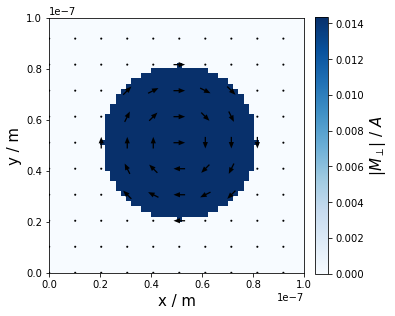

<class 'matplotlib.axes._subplots.AxesSubplot'>
[  5.00000000e-08   5.00000000e-08]


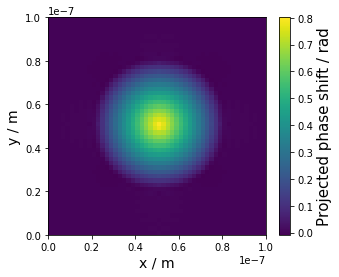

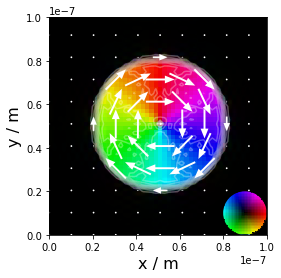

In [5]:
# calculations
    # M
MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.disc_vortex(bbox_length_px=50)
    # phase proj
phase = ma.calculate_phase_M_2D(MX,MY,MZ,mesh_params=mesh_params)
    # b proj
bmag,bx,by = ma.calculate_B_from_phase(phase,mesh_params=mesh_params)
    # A 3d
AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=100)
    # B 3d
BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params)

# plots
mx,my=ma.project_along_z(MX,mesh_params=mesh_params),ma.project_along_z(MY,mesh_params=mesh_params)
ma.plot_2d_mag(mx,my,mesh_params=mesh_params,s=5)
ma.plot_phase_proj(phase,mesh_params=mesh_params)
fig,ax=plt.subplots()
ma.plot_2d_B(bx,by,mesh_params=mesh_params,B_contour=True,ax=ax)
ma.plot_colorwheel(clip=1e-8,shape=np.shape(bx)[0]+100,rad=0.1,mesh_params=mesh_params,shift_centre=(60,-60),ax=ax)

## 4. Dual-axis Scheme

### 4.1 Generate dataset

In [5]:
# Create M, A and B in 3D
MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.disc_vortex(bbox_length_px=20,plan_rot=45)
#MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.sphere(bbox_length_px=50,rad_m=3e-8,plan_rot=45)
# A 3d
n=1
AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n)
# B 3d
BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)

In [7]:
# Generate angles and projected phase data
as_x,as_y,pxs,pys = dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= 30,a_range=90,n_pad=n)

In [8]:
# Generate projected B data
bxs,bys = dual_axis_B_generation(pxs,pys,mesh_params2)

In [76]:
dataset=[bxs,bys,as_x,as_y,mesh_params,BX,BY,BZ]
#np.save(r'recon_tests/vortex_91-proj_90-range_dual-sirt_data.npy',dataset)

### 4.2 B reconstruction from phase

In [14]:
# perform tomographic reconstruction on phase
px_recon,py_recon = dual_axis_reconstruction(pxs,pys,axs,ays,niter=100)

Text(0.5, 1, '|Difference| (COD 1.00)')

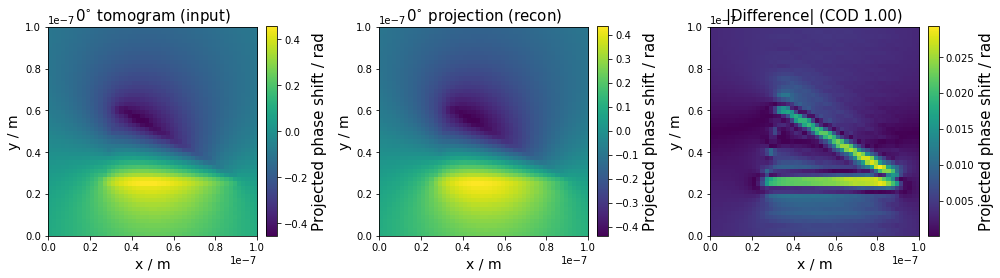

In [38]:
# compare 0 deg projection of input vs reconstruction
f,ax = plt.subplots(ncols=3,figsize=(14,9))
i=45
data = px[:,i,:]
a = axs[i]
recon = px_recon
# if angle is not 0
recon = ma.rotate_bulk(recon,a[0],a[1],a[2])
recon = ma.project_along_z(recon)#,mesh_params=mesh_params2)

ma.plot_phase_proj(np.flipud(data).T[n:-n,n:-n],mesh_params=mesh_params,ax=ax[0])
ma.plot_phase_proj(recon[n:-n,n:-n],mesh_params=mesh_params,ax=ax[1])
ma.plot_phase_proj(np.abs(np.flipud(data).T-recon)[n:-n,n:-n],mesh_params=mesh_params,ax=ax[2])
plt.tight_layout()
ax[0].set_title(r'0$^{\circ}$ tomogram (input)',fontsize=15)
ax[1].set_title(r'0$^{\circ}$ projection (recon)',fontsize=15)
cod = ma.COD(recon[n:-n,n:-n],np.flipud(data).T[n:-n,n:-n])
ax[2].set_title(r'|Difference| (COD %.2f)' % cod,fontsize=15)

In [41]:
def dual_axis_calculate_Amix_from_phaserecon(p,mesh_params):
    p1,p2,n=mesh_params
    res = p2[0]/n[0]
    # no idea why factor of 10 is necessary
    AZ = -p * constants.codata.value('mag. flux quantum')/(np.pi) / res * 2*np.pi
    return AZ

def dual_axis_calculate_B_phaserecon(PX,PY,mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x_size = p2[0]
    x_res = x_size/n[0]
    
    y_size = p2[1]
    y_res = y_size/n[1]
    
    BX,BY,BZ = [],[],[]
    
    resx = p2[0]/n[0] # resolution in m per px 
    resy = p2[1]/n[1] # resolution in m per px 
    resz = p2[2]/n[2] # resolution in m per px 
    
    azx= dual_axis_calculate_Amix_from_phaserecon(PX,mesh_params)
    azy= dual_axis_calculate_Amix_from_phaserecon(PY,mesh_params)
    
    BX = np.gradient(azy,resy)[1]/(2*np.pi)
    BY = -np.gradient(azx,resx)[0]/(2*np.pi)
    
    dBZ = -1*(np.gradient(BX,resx)[0]+np.gradient(BY,resy)[1]) *resz
    
    BZ=[]
    old=0
    for i in range(np.shape(dBZ)[2]):
        dbz=dBZ[:,:,i]
        cum = dbz+old
        BZ.append(cum)
        old=cum 
    #BZ -= np.mean(BZ)
    
#     # somehow the axes are in the wrong order and this fixes it
#     BX = np.transpose(BX,axes=[1,2,0])
#     BY = np.transpose(BY,axes=[1,2,0])
#     BZ = np.transpose(BZ,axes=[1,2,0])
    
    return np.array(BX),np.array(BY),np.array(BZ)

In [45]:
bx_p,by_p,bz_p = dual_axis_calculate_B_phaserecon(px_recon,py_recon,mesh_params=mesh_params2)

In [14]:
plt.imshow(bx_p[:,:,n+25])
plt.colorbar()
plt.show()
plt.imshow(BX[:,:,n+25])
plt.colorbar()

NameError: name 'bx_p' is not defined

### 4.3 Reconstruction from B projections

In [3]:
bxs,bys,as_x,as_y,mesh_params,BX,BY,BZ = np.load(r'recon_tests/vortex_91-proj_90-range_dual-sirt_data.npy')
n=100
mesh_params2=mesh_params

In [4]:
# perform tomographic reconstruction on projected b fields
n_iter=100
bx_recon,by_recon = dual_axis_reconstruction(bxs,bys,as_x,as_y,mesh_params,niter=n_iter,algorithm='SIRT3D_CUDA',callback_freq=5)

In [ ]:
# perform tomographic reconstruction on projected b fields
n_iter=100
bx_recon2,by_recon2 = dual_axis_reconstruction(bxs,bys,as_x,as_y,mesh_params,niter=n_iter,algorithm='SIRT3D_CUDA',callback_freq=5)

In [34]:
bz_recon = dual_axis_bz_from_bxby(bx_recon,by_recon)

In [6]:
codx = ma.COD(BX[n:-n,n:-n,n:-n],bx_recon[n:-n,n:-n,n:-n])
cody = ma.COD(BY[n:-n,n:-n,n:-n],by_recon[n:-n,n:-n,n:-n])
codz = ma.COD(BZ[n:-n,n:-n,n:-n],bz_recon[n:-n,n:-n,n:-n])
print(codx,cody,codz)

0.680388622371 0.680381124555 0.0068345562002


In [22]:
pex = ma.phantom_error(BX[n:-n,n:-n,n:-n],bx_recon[n:-n,n:-n,n:-n])
pey = ma.phantom_error(BY[n:-n,n:-n,n:-n],by_recon[n:-n,n:-n,n:-n])
pez = ma.phantom_error(BZ[n:-n,n:-n,n:-n],bz_recon[n:-n,n:-n,n:-n])
print(pex,pey,pez)

0.5653418555498538 0.565348449329757 0.9965768631615625


In [19]:
def test_metric(A,B,fun):
    print('Actual \t',fun(A,A))
    print('Data \t',fun(A,B))
    print('Random 1e-10 \t',fun(A,np.zeros_like(B)-(1e-10)*(0.05+0.1*np.random.rand(np.shape(B)[0],np.shape(B)[1],np.shape(B)[2]))))
    print('Random 1e0 \t',fun(A,np.ones_like(B)-0.05+0.1*np.random.rand(np.shape(B)[0],np.shape(B)[1],np.shape(B)[2])))
    print('Random 1e10\t',fun(A,1e10*(0.5-np.ones_like(B)*np.random.rand(np.shape(B)[0],np.shape(B)[1],np.shape(B)[2]))))
    
print('COD')    
test_metric(BZ[n:-n,n:-n,n:-n],bz_recon[n:-n,n:-n,n:-n],ma.COD)
print('\nCC') 
test_metric(BZ[n:-n,n:-n,n:-n],bz_recon[n:-n,n:-n,n:-n],CC)
print('\nNRMSE') 
test_metric(BX[n:-n,n:-n,n:-n],bz_recon[n:-n,n:-n,n:-n],NRMSE)
print('\nMAAPE') 
test_metric(BZ[n:-n,n:-n,n:-n],bz_recon[n:-n,n:-n,n:-n],MAAPE)
print('\nPE') 
test_metric(BZ[n:-n,n:-n,n:-n],bz_recon[n:-n,n:-n,n:-n],ma.phantom_error)

COD
Actual 	 1.0
Data 	 0.0503891702222
Random 1e-10 	 2.3088794888e-05
Random 1e0 	 1.83060139468e-06
Random 1e10	 7.42517220616e-06

CC
Actual 	 1.0
Data 	 0.224475310263
Random 1e-10 	 -0.000739982532761
Random 1e0 	 -0.000147735948201
Random 1e10	 -0.00260039142621

NRMSE
Actual 	 0.0
Data 	 0.129733058285
Random 1e-10 	 0.1206991776
Random 1e0 	 0.754273026087
Random 1e10	 2211124997.96

MAAPE
Actual 	 0.0
Data 	 0.957923587214
Random 1e-10 	 0.785398162784
Random 1e0 	 1.54981397719
Random 1e10	 1.57079632675

PE
Actual 	 0.0
Data 	 0.9744797687819846
Random 1e-10 	 1.0
Random 1e0 	 0.9999998268849898
Random 1e10	 236.12650926675988


In [78]:
data = np.load(r'recon_tests/sphere_91-proj_90-range_dual-sirt.npy')
row = [n_iter,codx,cody,codz]
data = np.append(data,row)
np.save(r'recon_tests/sphere_91-proj_90-range_dual-sirt.npy',data)

FileNotFoundError: [Errno 2] No such file or directory: 'recon_tests/sphere_91-proj_90-range_dual-sirt.npy'

Text(0.5, 1.0, 'SIRT reconstructions')

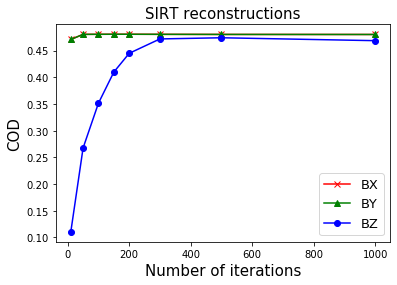

In [34]:
data=np.reshape(data,(8,4))
ns=[]
cxs = []
cys=[]
czs=[]
for row in data:
    n=row[0]
    codx=row[1]
    cody=row[2]
    codz=row[3]
    ns.append(n)
    cxs.append(codx)
    cys.append(cody)
    czs.append(codz)
    
plt.plot(ns,cxs,'rx-',label='BX')
plt.plot(ns,cys,'g^-',label='BY')
plt.plot(ns,czs,'bo-',label='BZ')
plt.xlabel('Number of iterations',fontsize=15)
plt.ylabel('COD',fontsize=15)
plt.legend(fontsize=13)
plt.title('SIRT reconstructions',fontsize=15)

Text(0.5, 1, '|Difference| (COD 1.00)')

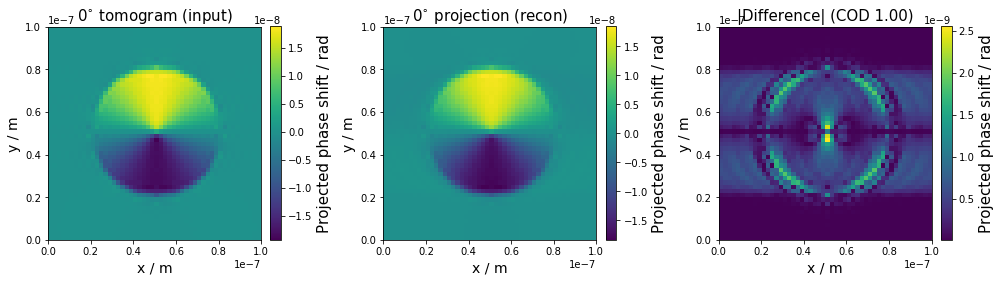

In [8]:
# check projections of input vs recon
f,ax = plt.subplots(ncols=3,figsize=(14,9))
i=45 # projection number

data = bxs[:,i,:]
a = as_y[i]
recon = bx_recon

# data = bys[:,i,:]
# a = as_x[i]
# recon = by_recon

recon = ma.rotate_bulk(recon,a[0],a[1],a[2])
recon = ma.project_along_z(recon,mesh_params=mesh_params2)

ma.plot_phase_proj(data[n:-n,n:-n],mesh_params=mesh_params,ax=ax[0])
ma.plot_phase_proj(recon[n:-n,n:-n],mesh_params=mesh_params,ax=ax[1])
ma.plot_phase_proj(np.abs(data-recon)[n:-n,n:-n],mesh_params=mesh_params,ax=ax[2])
plt.tight_layout()
ax[0].set_title(r'0$^{\circ}$ tomogram (input)',fontsize=15)
ax[1].set_title(r'0$^{\circ}$ projection (recon)',fontsize=15)
cod = ma.COD(data[n:-n,n:-n],recon[n:-n,n:-n])
ax[2].set_title(r'|Difference| (COD %.2f)' % cod,fontsize=15)

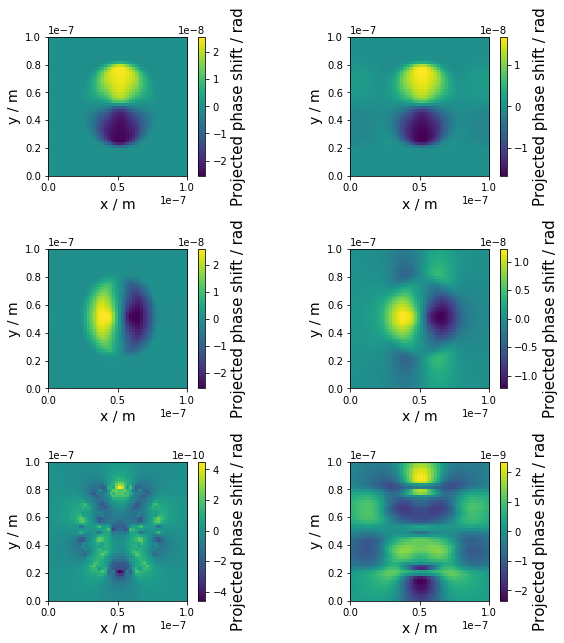

In [11]:
# compare projections at any angle

a = [0,45,0]
originals = [BX,BY,BZ]
recons = [bx_recon,by_recon,bz_recon]

for i in [0,1,2]:
    originals[i] = originals[i][n:-n,n:-n]
    recons[i] = recons[i][n:-n,n:-n]
    originals[i] = ma.rotate_bulk(originals[i],a[0],a[1],a[2])
    originals[i] = ma.project_along_z(originals[i],mesh_params=mesh_params2)
    recons[i] = ma.rotate_bulk(recons[i],a[0],a[1],a[2])
    recons[i] = ma.project_along_z(recons[i],mesh_params=mesh_params2)

f,ax = plt.subplots(ncols=2,nrows=3,figsize=(9,9))
ma.plot_phase_proj(originals[0],mesh_params=mesh_params,ax=ax[0,0])
ma.plot_phase_proj(recons[0],mesh_params=mesh_params,ax=ax[0,1])
ma.plot_phase_proj(originals[1],mesh_params=mesh_params,ax=ax[1,0])
ma.plot_phase_proj(recons[1],mesh_params=mesh_params,ax=ax[1,1])
ma.plot_phase_proj(originals[2],mesh_params=mesh_params,ax=ax[2,0])
ma.plot_phase_proj(recons[2],mesh_params=mesh_params,ax=ax[2,1])

plt.tight_layout()

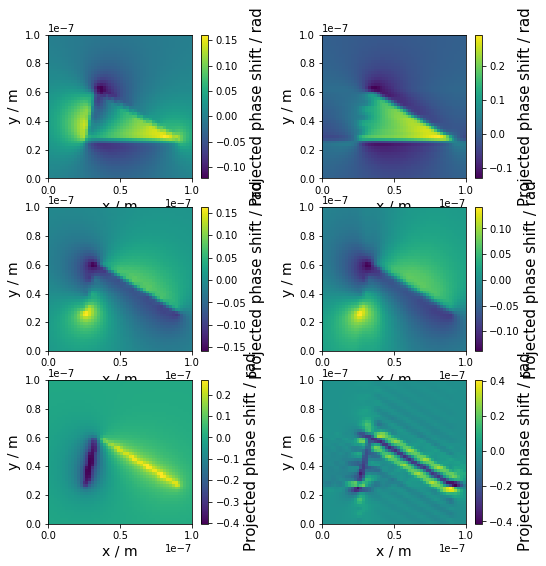

In [24]:
# compare z slices
x_slice = False
y_slice = False
z_slice = 40
originals = [BX,BY,BZ]
recons = [bx_recon,by_recon,bz_recon]

for i in [0,1,2]:
    originals[i] = originals[i][n:-n,n:-n,n:-n]
    recons[i] = recons[i][n:-n,n:-n,n:-n]
    if x_slice != False:
        originals[i] = originals[i][x_slice,:,:]
        recons[i] = recons[i][x_slice,:,:]
    if y_slice != False:
        originals[i] = originals[i][:,y_slice,:]
        recons[i] = recons[i][:,y_slice,:]
    if z_slice != False:
        originals[i] = originals[i][:,:,z_slice]
        recons[i] = recons[i][:,:,z_slice]

f,ax = plt.subplots(ncols=2,nrows=3,figsize=(9,9))
ma.plot_phase_proj(originals[0],mesh_params=mesh_params,ax=ax[0,0])
ma.plot_phase_proj(recons[0],mesh_params=mesh_params,ax=ax[0,1])
ma.plot_phase_proj(originals[1],mesh_params=mesh_params,ax=ax[1,0])
ma.plot_phase_proj(recons[1],mesh_params=mesh_params,ax=ax[1,1])
ma.plot_phase_proj(originals[2],mesh_params=mesh_params,ax=ax[2,0])
ma.plot_phase_proj(recons[2],mesh_params=mesh_params,ax=ax[2,1])

## 5. Multi-axis reconstruction

In [27]:
# Create M, A and B in 3D
MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.tri_pris(bbox_length_px=50,plan_rot=45)
#MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.sphere(bbox_length_px=50,rad_m=3e-8,plan_rot=45)
# A 3d
n=100
AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n)
# B 3d
BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)

In [30]:
# generate angles
angles = ma.generate_angles(mode='dual',n_tilt=182,alpha=90,beta=90)

In [36]:
# generate phase data
phases = generate_phase_data(MX,MY,MZ,angles,mesh_params=mesh_params,n_pad=n,unpad=False)

In [33]:
# generate weights
# normal == e- direction, so A.dir is what contributes to phase
normals = []
for a in angles:
    # calculate plane normal
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    normal = np.dot(mrot,[0,0,1])
    normals.append(normal)

In [52]:
normals

[array([  0.00000000e+00,   1.00000000e+00,   6.12323400e-17]),
 array([ 0.        ,  0.99939083,  0.0348995 ]),
 array([ 0.        ,  0.99756405,  0.06975647]),
 array([ 0.        ,  0.9945219 ,  0.10452846]),
 array([ 0.        ,  0.99026807,  0.1391731 ]),
 array([ 0.        ,  0.98480775,  0.17364818]),
 array([ 0.        ,  0.9781476 ,  0.20791169]),
 array([ 0.        ,  0.97029573,  0.2419219 ]),
 array([ 0.        ,  0.9612617 ,  0.27563736]),
 array([ 0.        ,  0.95105652,  0.30901699]),
 array([ 0.        ,  0.93969262,  0.34202014]),
 array([ 0.        ,  0.92718385,  0.37460659]),
 array([ 0.        ,  0.91354546,  0.40673664]),
 array([ 0.        ,  0.89879405,  0.43837115]),
 array([ 0.        ,  0.88294759,  0.46947156]),
 array([ 0.       ,  0.8660254,  0.5      ]),
 array([ 0.        ,  0.8480481 ,  0.52991926]),
 array([ 0.        ,  0.82903757,  0.5591929 ]),
 array([ 0.        ,  0.80901699,  0.58778525]),
 array([ 0.        ,  0.78801075,  0.61566148]),
 array([

In [62]:
# generate a new set of projections, reweighted to their AX/AY/AZ contributions
ax = []
a_ax = []
ay = []
a_ay = []
az = []
a_az = []
for i,n in enumerate(normals):
    p = phases[:,i,:]
    if abs(n[0]) > 1e-3:
        axx = p*(1/n[0])
        ax.append(axx)
        a_ax.append(angles[i])
    if abs(n[1]) > 1e-3:
        ayy = p*(1/n[1])
        ay.append(ayy)
        a_ay.append(angles[i])
    if abs(n[2]) > 1e-3:
        azz = p*(1/n[2])
        az.append(azz)
        a_az.append(angles[i])
        
ax = np.transpose(ax,axes=[1,0,2])
ay = np.transpose(ay,axes=[1,0,2])
az = np.transpose(az,axes=[1,0,2])

In [64]:
p1,p2,nn = mesh_params
res = p2[0]/nn[0]

In [63]:
vecs = ma.generate_vectors(a_ax)
rx = ma.generate_reconstruction(ax,vecs, algorithm = 'SIRT3D_CUDA', niter=100)

# Restructure data to match input M/A/B/p
rx = np.transpose(rx,axes=(2,1,0))[:,::-1,:]
rx = np.transpose(rx[::1,::-1,::1],axes=[1,0,2])
rx = rx/res

ax_recon = rx

NameError: name 'resx' is not defined

In [ ]:
vecs = ma.generate_vectors(a_ay)
rx = ma.generate_reconstruction(ay,vecs, algorithm = 'SIRT3D_CUDA', niter=100)

# Restructure data to match input M/A/B/p
rx = np.transpose(rx,axes=(2,1,0))[:,::-1,:]
rx = np.transpose(rx[::1,::-1,::1],axes=[1,0,2])
rx = rx/res

ay_recon = rx

In [2]:
free -h

NameError: name 'free' is not defined

## MESS

Quick check of all orientations vs original

(-0.5, 49.5, 49.5, -0.5)

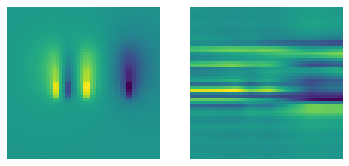

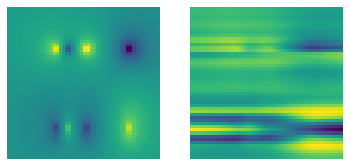

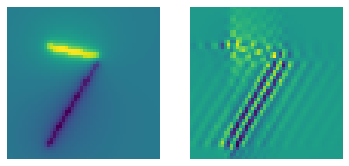

In [36]:
b = bz_recon
#b=b[:,:,::1]
#b= np.transpose(b[::1,::-1,::1],axes=[1,0,2])
i = n+16

f,axs=plt.subplots(ncols=2)
im1=axs[0].imshow(BZ[i,:,:][n:-n,n:-n])
im2=axs[1].imshow(b[i,:,:][n:-n,n:-n])
axs[0].axis('off')
axs[1].axis('off')

f,axs=plt.subplots(ncols=2)
im1=axs[0].imshow(BZ[:,i,:][n:-n,n:-n])
im2=axs[1].imshow(b[:,i,:][n:-n,n:-n])
axs[0].axis('off')
axs[1].axis('off')

f,axs=plt.subplots(ncols=2)
im1=axs[0].imshow(BZ[:,:,i][n:-n,n:-n])
im2=axs[1].imshow(b[:,:,i][n:-n,n:-n])
axs[0].axis('off')
axs[1].axis('off')

Quick check of slices through series

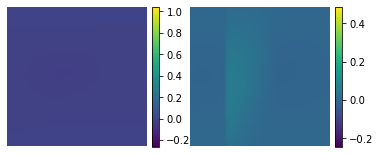

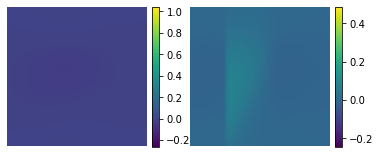

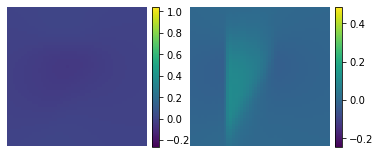

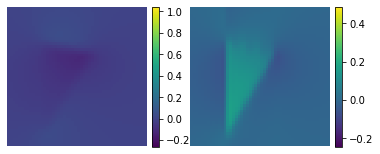

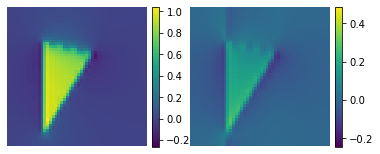

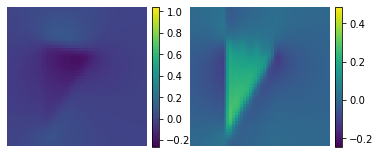

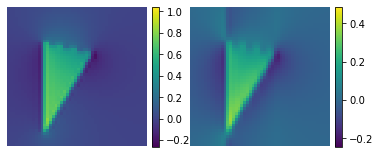

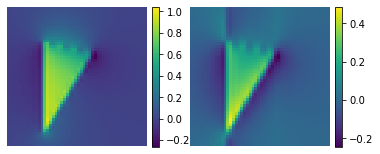

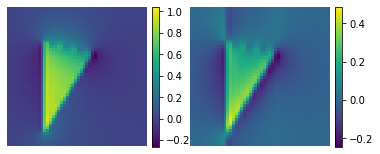

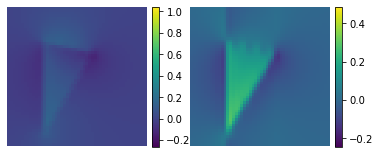

In [55]:
# check slices of input vs recon
BX = np.array(BX)
for i in np.linspace(n,n+40,10):
    f,axs=plt.subplots(ncols=2)
    i=int(i)
    im1=axs[0].imshow(BX[:,:,i][n:-n,n:-n],vmin=np.min(BX[n:-n,n:-n,n:-n]),vmax=np.max(BX[n:-n,n:-n,n:-n]))
    im2=axs[1].imshow(bx_recon[:,:,i][n:-n,n:-n],vmin=np.min(bx_recon[n:-n,n:-n]),vmax=np.max(bx_recon[n:-n,n:-n]))
#     im1=axs[0].imshow(BY[:,:,i][n:-n,n:-n],vmin=np.min(BY),vmax=np.max(BY))
#     im2=axs[1].imshow(by_recon[:,:,i][n:-n,n:-n],vmin=np.min(by_recon),vmax=np.max(by_recon))

    axs[0].axis('off')
    axs[1].axis('off')
    f.colorbar(im1,ax=axs[0],fraction=0.046, pad=0.04)
    f.colorbar(im2,ax=axs[1],fraction=0.046, pad=0.04)
    plt.show()

Changing recon parameters

In [ ]:
data = np.load(r'recon_tests/sphere_91-proj_90-range_dual-TV2-001.npy')
for n_iter in [10,50,100,150,200,300,400,500,1000]:
    bx_recon,by_recon = dual_axis_reconstruction(bxs,bys,as_x,as_y,mesh_params,niter=n_iter,algorithm='TV2',callback_freq=5)
    bz_recon = dual_axis_bz_from_bxby(bx_recon,by_recon)
    codx = ma.COD(BX[n:-n,n:-n,n:-n],bx_recon[n:-n,n:-n,n:-n])
    cody = ma.COD(BY[n:-n,n:-n,n:-n],by_recon[n:-n,n:-n,n:-n])
    codz = ma.COD(BZ[n:-n,n:-n,n:-n],bz_recon[n:-n,n:-n,n:-n])
    row = [n_iter,codx,cody,codz]
    np.append(data,row)
    np.save(r'recon_tests/sphere_91-proj_90-range_dual-TV2-001.npy',data)

 Iter   Time      primal          gap        violation       step     
   0%     6s     1.075e+03     1.000e+00          0        0.000e+00  


In [ ]:
vecs = ma.generate_vectors(angles_x)
bx3 = ma.generate_reconstruction(bxs,vecs, algorithm = 'SIRT3D_CUDA', niter=100, weight = 0.001,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

vecs = ma.generate_vectors(angles_y)
by3 = ma.generate_reconstruction(bys,vecs, algorithm = 'SIRT3D_CUDA', niter=100, weight = 0.01,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

bx3 = np.transpose(bx3,axes=(2,1,0))[:,::-1,:]
by3 = np.transpose(by3,axes=(2,1,0))[:,::-1,:]

In [44]:
bx 

array([[  1.58781155e-10,   1.58755527e-10,   1.58666078e-10, ...,
          1.58349085e-10,   1.58565333e-10,   1.58654356e-10],
       [  1.58950601e-10,   1.58954263e-10,   1.58923356e-10, ...,
          1.58313643e-10,   1.58588434e-10,   1.58706717e-10],
       [  1.59196506e-10,   1.59229421e-10,   1.59257061e-10, ...,
          1.58354623e-10,   1.58687961e-10,   1.58835529e-10],
       ..., 
       [  1.58731300e-10,   1.58617870e-10,   1.58352786e-10, ...,
          1.58913961e-10,   1.58954574e-10,   1.58955772e-10],
       [  1.58671501e-10,   1.58587331e-10,   1.58380793e-10, ...,
          1.58649244e-10,   1.58748403e-10,   1.58778880e-10],
       [  1.58688102e-10,   1.58633218e-10,   1.58485223e-10, ...,
          1.58460954e-10,   1.58618655e-10,   1.58678396e-10]])

In [223]:
# Generate phase projection data
#MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.sphere(bbox_length_px=25)
#MX,MY,MZ = rotate_magnetisation(MX,MY,MZ,ay=45,ax=45,az=45)
angles_x = ma.generate_angles(mode='x',n_tilt=40,alpha=90)
angles_y = ma.generate_angles(mode='y',n_tilt=40,beta=90,tilt2='beta')
phases_x = generate_phase_data(MX,MY,MZ,angles_x,mesh_params=mesh_params,n_pad=100)
phases_y = generate_phase_data(MX,MY,MZ,angles_y,mesh_params=mesh_params,n_pad=100)

In [298]:
# A 3d
AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=50)
# B 3d
BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)

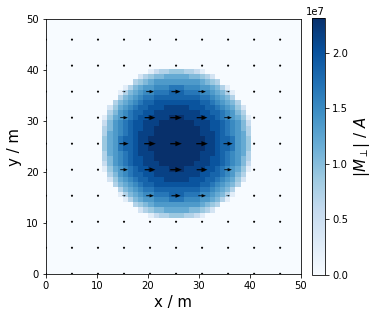

In [246]:
ma.plot_2d_mag(np.sum(MX,axis=2),np.sum(MY,axis=2),s=5)

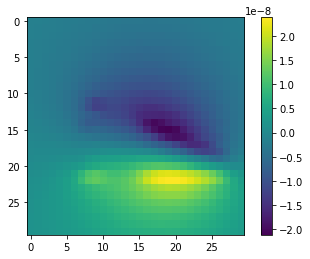

In [85]:
n=50
plt.imshow(-np.flipud(AZ[:,:,15+n].T)[n:-n,n:-n])
plt.colorbar()

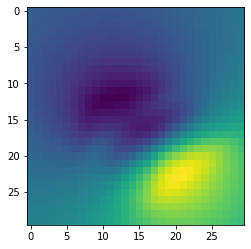

In [86]:
#ma.plot_phase_proj(phases_x[:,1,:],mesh_params=mesh_params)
plt.imshow(phases_x[:,30,:])
#ma.plot_phase_proj(raw_data[:,6,:])

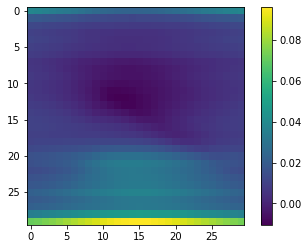

In [51]:
plt.imshow(np.flipud(rx[:,:,15].T))
plt.colorbar()

In [103]:
import open3d as o3d
import matplotlib
s=3 # set number of voxels to skip (increase speed)

# Convert grid to point cloud
points = np.transpose(np.where(rx[::s,::s,::s]>0.01))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

cmap = matplotlib.cm.get_cmap('viridis')
shape = np.shape(points)
cols = np.zeros_like(points,dtype=np.float16)
for i,p in enumerate(points):
    p = np.array(p)*s # account for skipping
    val = (rx[p[0],p[1],p[2]]-np.min(rx))/np.max(rx)

    c = cmap(val)
    cols[i,0] = c[0]
    cols[i,1] = c[1]
    cols[i,2] = c[2]
pcd.colors = o3d.utility.Vector3dVector(cols)

o3d.visualization.draw_geometries([pcd])

In [104]:
px = phases_x#-np.min(phases_x)
# px=px/np.max(px)
# plt.imshow(px[:,20,:])
# plt.colorbar()

In [224]:
vecs = ma.generate_vectors(angles_x)
recon_x = ma.generate_reconstruction(phases_x,vecs, algorithm = 'SIRT3D_CUDA', niter=40, weight = 0.001,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

vecs = ma.generate_vectors(angles_y)
recon_y = ma.generate_reconstruction(phases_y,vecs, algorithm = 'SIRT3D_CUDA', niter=40, weight = 0.01,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

In [225]:
rx = np.transpose(recon_x,axes=(2,1,0))[:,::-1,:]
ry = np.transpose(recon_y,axes=(2,1,0))[:,::-1,:]
# rx = ma.reorient_reconstruction(recon_x)
# ry = ma.reorient_reconstruction(recon_y)

In [232]:
np.shape(rx)

(50, 50, 50)

In [3]:
def plot_phase_proj(phase,mesh_params=None,ax=None):
    """ Plots the projected phase shift in rads """
    if mesh_params == None:
            p1 = (0,0,0)
            sx,sy = np.shape(phase)
            p2 = (sx,sy,sx)
            n = p2
    else:
        p1,p2,n = mesh_params
        
    if ax == None:
        fig,ax = plt.subplots()
    f=plt.gcf()
        

    im=ax.imshow(phase.T,extent=[p1[0],p2[0],p1[1],p2[1]],origin='lower')
    cbar = f.colorbar(im,fraction=0.046, pad=0.04,ax=ax)
    cbar.set_label('Projected phase shift / rad', rotation=-270,fontsize=15)
    ax.set_xlabel('x / m',fontsize=14)
    ax.set_ylabel('y / m',fontsize=14)
    
    if ax == None:
        plt.show()

Text(0.5, 1, '|Difference|')

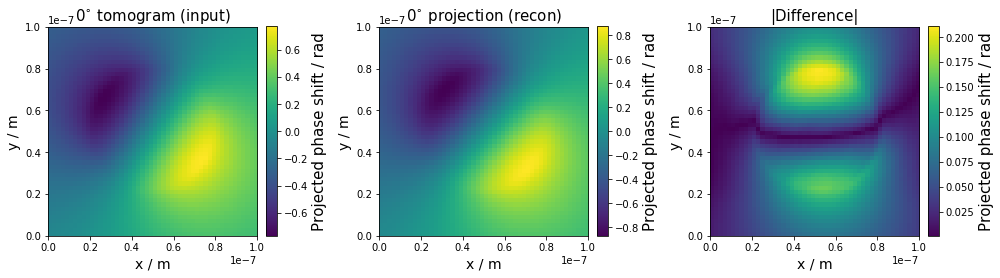

In [49]:
f,ax = plt.subplots(ncols=3,figsize=(14,9))
plot_phase_proj(np.flipud(phases_y[:,20,:]).T[n:-n,n:-n],mesh_params=mesh_params,ax=ax[0])
plot_phase_proj(np.sum(ry,axis=2)[n:-n,n:-n],mesh_params=mesh_params,ax=ax[1])
plot_phase_proj(np.abs(np.flipud(phases_y[:,20,:]).T-np.sum(ry,axis=2))[n:-n,n:-n],mesh_params=mesh_params,ax=ax[2])
plt.tight_layout()
ax[0].set_title(r'0$^{\circ}$ tomogram (input)',fontsize=15)
ax[1].set_title(r'0$^{\circ}$ projection (recon)',fontsize=15)
ax[2].set_title(r'|Difference|',fontsize=15)

In [4]:
def calculate_AZ_from_phase_recon(r,mesh_params):
    p1,p2,n=mesh_params
    res = p2[0]/n[0]
    # no idea why factor of 10 is necessary
    AZ = -r * constants.codata.value('mag. flux quantum')/(np.pi) / res * 2*np.pi
    return AZ

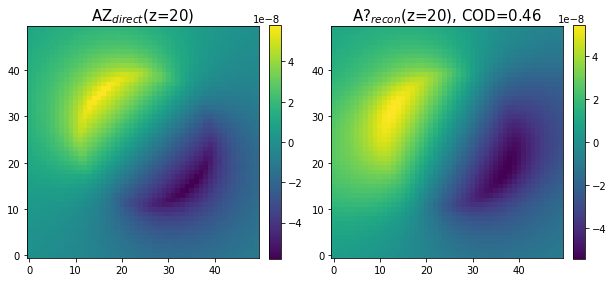

In [58]:
f,axs=plt.subplots(ncols=2,figsize=(10,5))
n=100
i=20
im=axs[0].imshow(AZ[:,:,i+n][n:-n,n:-n].T,origin='lower')#,vmin=np.min(AZ),vmax=np.max(AZ))
f.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)
axs[0].set_title('AZ$_{direct}$(z=%i)'%(i),fontsize=15)

azn= calculate_AZ_from_phase_recon(ry,mesh_params)
# '3D phase' projected and slice - reconstructed
im=axs[1].imshow(azn[:,:,i+n][n:-n,n:-n].T,origin='lower')#,vmin=np.min(azn),vmax=np.max(azn))
f.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)
cod = ma.COD(AZ[:,:,i+n][n:-n,n:-n],azn[:,:,i][n:-n,n:-n])
axs[1].set_title('A?$_{recon}$(z=%i), COD=%.2f'%(i,cod),fontsize=15)

cod = ma.COD(AZ[:,:,i+n][n:-n,n:-n],azn[:,:,i][n:-n,n:-n])

Text(0, 0.5, 'A / Am-1')

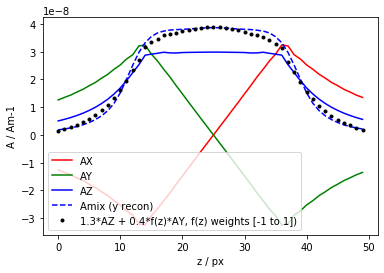

In [134]:
i=15
plt.plot(AX[n+15,n+25,n:-n].T,'r',label='AX')
plt.plot(AY[n+15,n+25,n:-n].T,'g',label='AY')
plt.plot(AZ[n+15,n+25,n:-n].T,'b',label='AZ')
plt.plot(azn[n+15,n+25,n:-n].T,'b--',label='Amix (y recon)')
plt.plot(1.3*AZ[n+15,n+25,n:-n].T-.4*AY[n+15,n+25,n:-n].T*np.linspace(1,-1,50),'.k',label='1.3*AZ + 0.4*f(z)*AY, f(z) weights [-1 to 1])')
plt.legend()
plt.xlabel('z / px')
plt.ylabel('A / Am-1')

In [97]:
bz3=[]
old=0
dBZ = -1*(np.gradient(bx3,resx)[0]+np.gradient(by3,resy)[1]) *resx
for i in range(np.shape(dBZ)[2]):
    dbz=dBZ[:,:,i]
    cum = dbz+old
    bz3.append(cum)
    old=cum 

In [99]:
bz3=np.array(bz3)/resx/(2*np.pi)

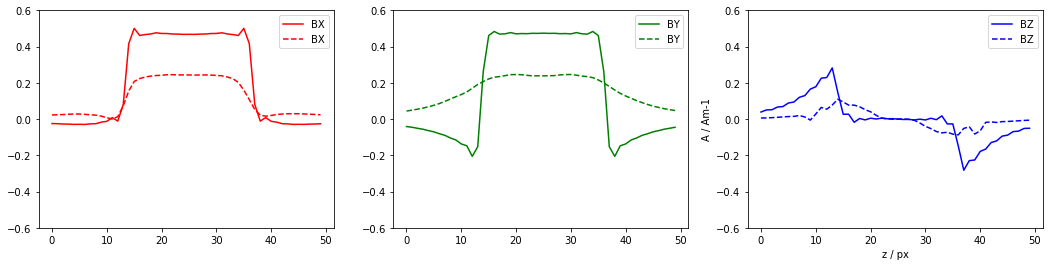

In [105]:
i=20
f,axs=plt.subplots(ncols=3,figsize=(18,4))
axs[0].plot(BX[n+15,n+25,n:-n].T,'r',label='BX')
axs[1].plot(BY[n+15,n+25,n:-n].T,'g',label='BY')
axs[2].plot(BZ[n+15,n+25,n:-n].T,'b',label='BZ')
axs[0].plot(-bx3[n+15,n+25,n:-n].T/resx,'r--',label='BX')
axs[1].plot(by3[n+15,n+25,n:-n].T/resx,'g--',label='BY')
axs[2].plot(-bz3[n+15,n+25,n:-n].T,'b--',label='BZ')
#plt.plot(-bz2[:,:,i+n][i+n,n:-n].T,'b--',label='BZ (Recon)')
#axs[2].plot(BZ[:,:,i+n][i+n,n:-n].T-0.2*BX[:,:,i+n][i+n,n:-n].T-.2*BY[:,:,i+n][i+n,n:-n].T,'.k',label='AZ+.4*AY')

# resy=mesh_params[1][1]/mesh_params[2][1]
# resx=mesh_params[1][0]/mesh_params[2][0]
# a = np.gradient(AY,resy)[1]/(2*np.pi)
# b = -np.gradient(AX,resx)[0]/(2*np.pi)

# axs[2].plot(a[:,:,i+n][i+n,n:-n].T)
# axs[2].plot(b[:,:,i+n][i+n,n:-n].T)

axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.xlabel('z / px')
plt.ylabel('A / Am-1')

for ax in axs:
    ax.set_ylim([-.6,.6])

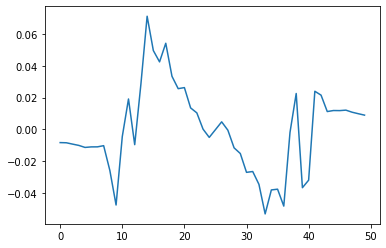

In [80]:
plt.plot(bz3[n+15,n+25,n:-n].T)

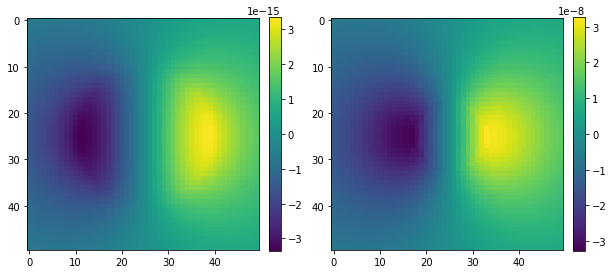

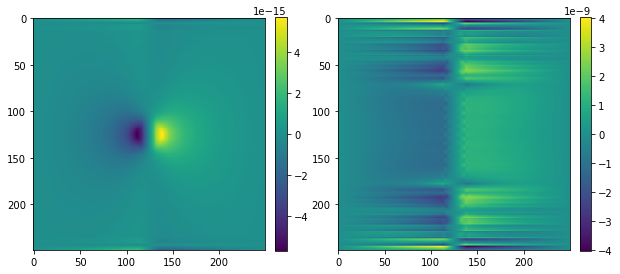

ValueError: operands could not be broadcast together with shapes (50,50,50) (250,250,250) 

In [214]:
# AZ projected and slice - directly calculated
f,axs=plt.subplots(ncols=2,figsize=(10,5))
n=100
# projection
im=axs[0].imshow(ma.project_along_z(AZ[n:-n,n:-n,n:-n],mesh_params=mesh_params))
f.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)

# slice
im=axs[1].imshow(AZ[:,:,12+n][n:-n,n:-n])
f.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)
plt.show()

azn= calculate_AZ_from_phase_recon(ry,mesh_params)

# '3D phase' projected and slice - reconstructed
f,axs=plt.subplots(ncols=2,figsize=(10,5))
# projection
im=axs[0].imshow(ma.project_along_z(azn,mesh_params=mesh_params))
f.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)
# slice
im=axs[1].imshow(azn[:,:,12])
f.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)
plt.show()

ma.COD(AZ[n:-n,n:-n,n:-n],azn)

In [5]:
def calculate_B_dual(PX,PY,mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x_size = p2[0]
    x_res = x_size/n[0]
    
    y_size = p2[1]
    y_res = y_size/n[1]
    
    BX,BY,BZ = [],[],[]
    
    resx = p2[0]/n[0] # resolution in m per px 
    resy = p2[1]/n[1] # resolution in m per px 
    resz = p2[2]/n[2] # resolution in m per px 
    
    for i in range(np.shape(PX)[2]):
        px = PX[:,:,i]
        py = PY[:,:,i]
        d_phase_x = np.gradient(px,resx)
        d_phase_y = np.gradient(py,resy)
#         plt.imshow(d_phase_y[1])
#         plt.show()
        b_const = (constants.codata.value('mag. flux quantum')/(np.pi))
        b_field_x = -b_const*d_phase_y[1] / resx 
        b_field_y = b_const*d_phase_x[0] / resy 
        b_field_z = -1*(np.gradient(b_field_x,resz)[0]+np.gradient(b_field_y,resz)[1])*resz
        
        BX.append(b_field_x)
        BY.append(b_field_y)
        BZ.append(b_field_z)
        
    # somehow the axes are in the wrong order and this fixes it
    BX = np.transpose(BX,axes=[1,2,0])
    BY = np.transpose(BY,axes=[1,2,0])
    BZ = np.transpose(BZ,axes=[1,2,0])
    
    return np.array(BX),np.array(BY),np.array(BZ)

In [97]:
mesh_params

[(0, 0, 0),
 (1.0000000000000001e-07, 1.0000000000000001e-07, 1.0000000000000001e-07),
 (30, 30, 30)]

In [227]:
bx,by,bz = calculate_B_dual(rx,ry,mesh_params=mesh_params)

In [49]:
bxproj, byproj = ma.project_along_z(bx,mesh_params=mesh_params),ma.project_along_z(by,mesh_params=mesh_params)

In [314]:
ma.COD(bz,BZ[n:-n,n:-n,n:-n])

1.663071358892591e-11

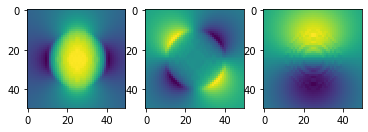

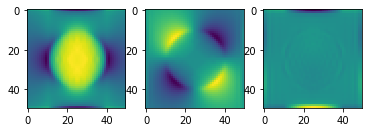

In [240]:
# B directly from A at the start
f,axs=plt.subplots(ncols=3)
axs[0].imshow(np.sum(BX[n:-n,n:-n,n:-n],axis=2))
axs[1].imshow(np.sum(BY[n:-n,n:-n,n:-n],axis=2))
axs[2].imshow(np.sum(BZ[n:-n,n:-n,n:-n],axis=2))


# reconstructed B
f,axs=plt.subplots(ncols=3)
axs[0].imshow(np.sum(bx,axis=2))
axs[1].imshow(np.sum(by,axis=2))
axs[2].imshow(np.sum(bz,axis=2))

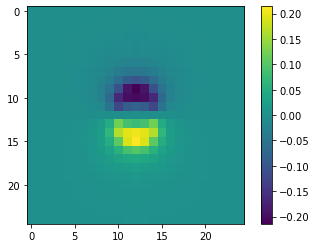

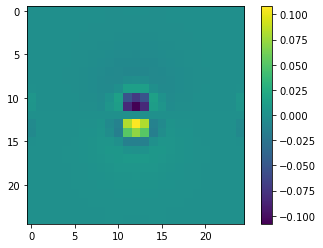

In [367]:
n=50
BXc = BX[n:-n,n:-n,n:-n]
BYc = BY[n:-n,n:-n,n:-n]
BZc = BZ[n:-n,n:-n,n:-n]

BZc = BZ[n:-n,n:-n,n:-n]
plt.imshow(BZc[:,:,14])
plt.colorbar()
plt.show()

BZ2 = -1*(np.gradient(BXc)[0]+np.gradient(BYc)[1])
plt.imshow(BZ2[:,:,14])
plt.colorbar()

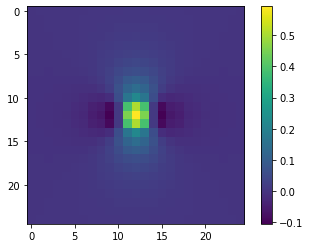

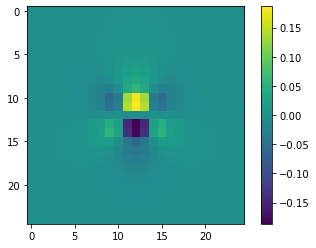

In [375]:
plt.imshow(BXc[:,:,14])
plt.colorbar()
plt.show()
plt.imshow(np.gradient(BXc[:,:,14])[0])
plt.colorbar()

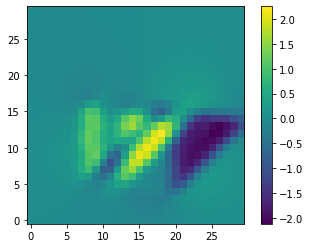

In [292]:
BXc = BX[n:-n,n:-n,n:-n]
BYc = BY[n:-n,n:-n,n:-n]
BZc = BZ[n:-n,n:-n,n:-n]

BZ2 = -1*(np.gradient(BZ)[0]+np.gradient(BY)[1])
bz2 = -1*(np.gradient(bx)[0]+np.gradient(by)[1])

plt.imshow(np.sum(BZ2[n:-n,n:-n],axis=2).T,origin='lower')
#plt.imshow(np.sum(np.gradient(BXc)[1],axis=2).T,origin='lower')
plt.colorbar()

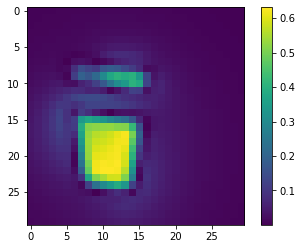

In [287]:
plt.imshow(abs(BZc[:,:,15]))
plt.colorbar()

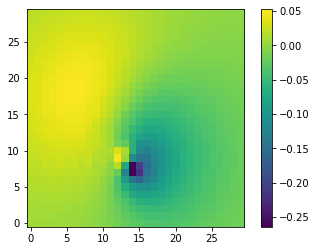

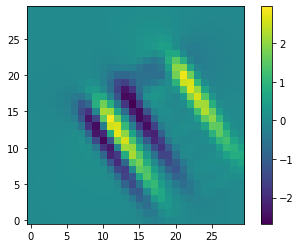

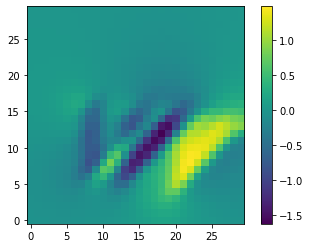

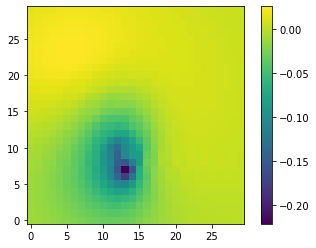

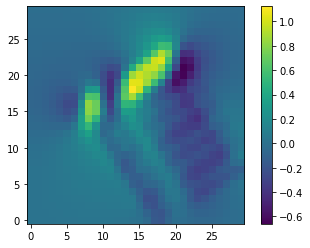

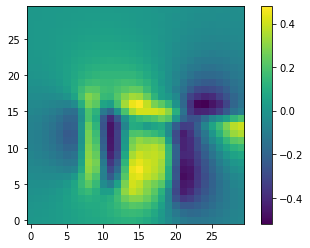

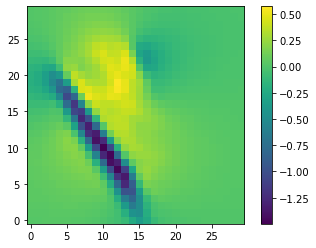

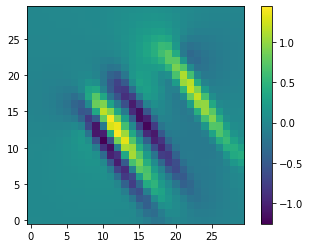

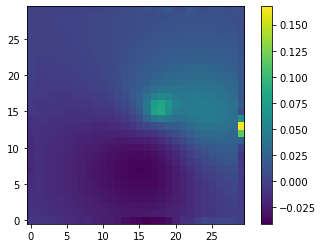

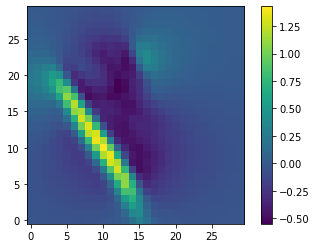

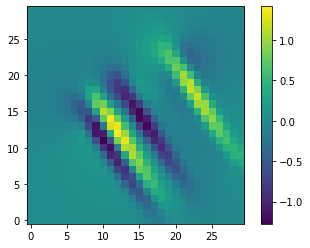

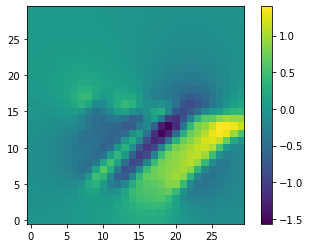

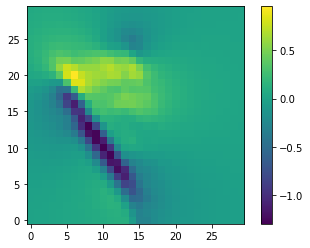

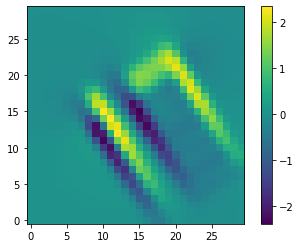

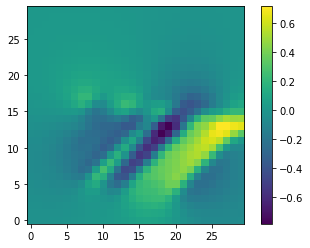

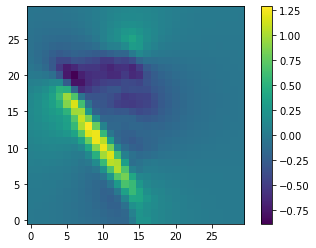

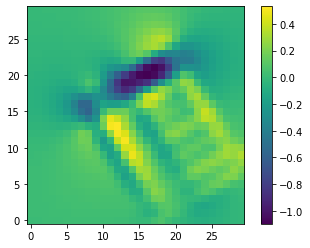

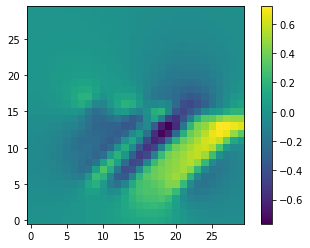

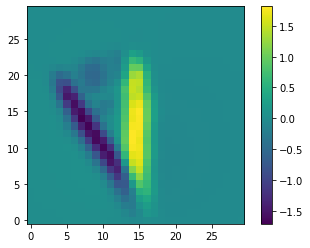

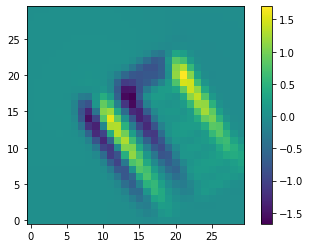

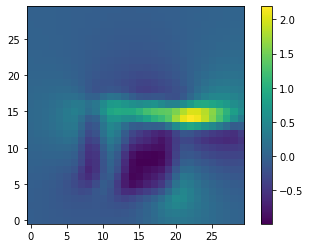

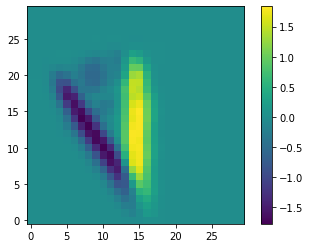

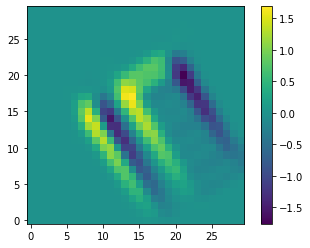

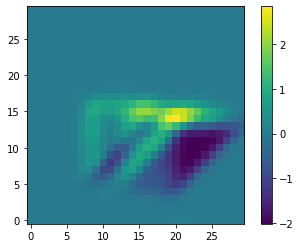

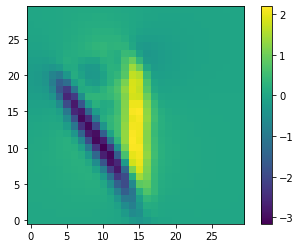

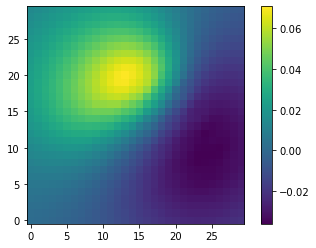

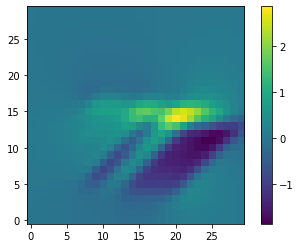

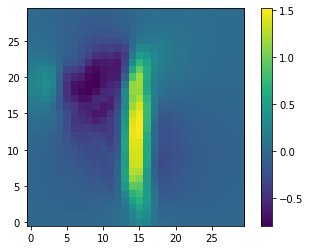

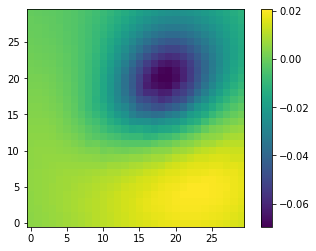

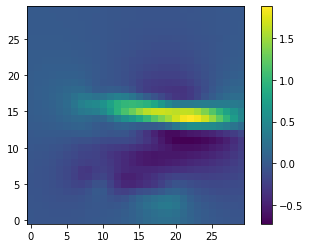

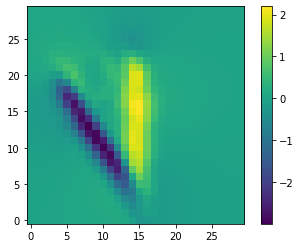

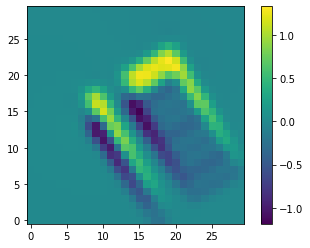

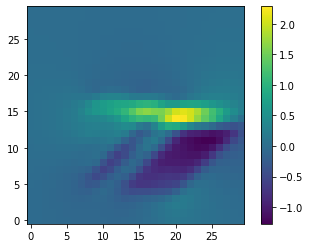

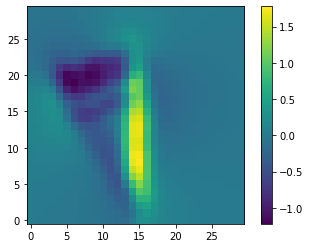

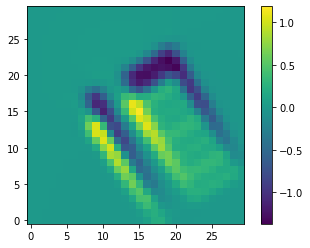

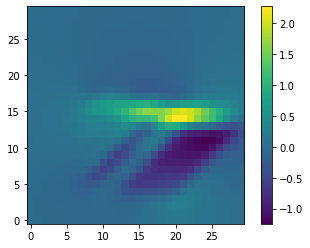

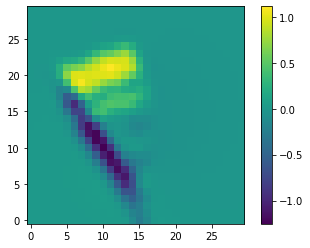

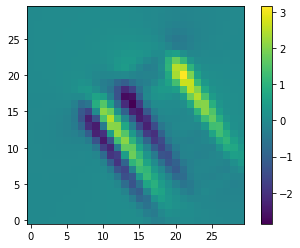

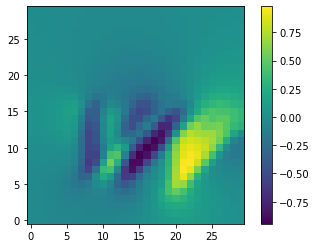

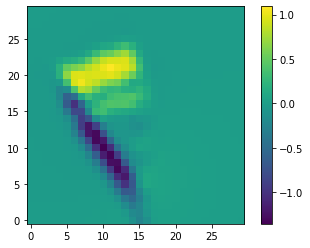

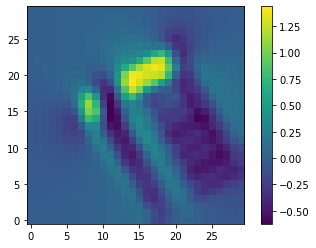

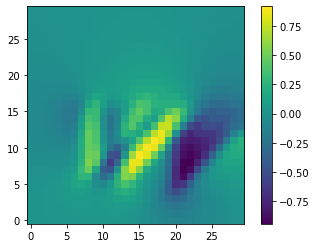

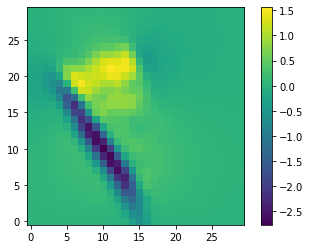

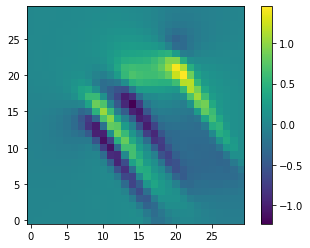

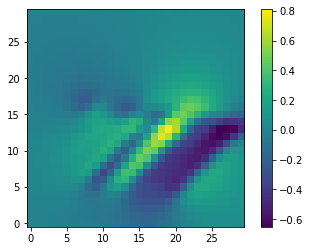

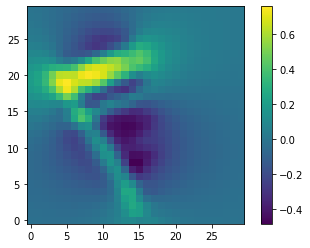

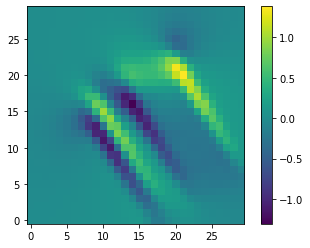

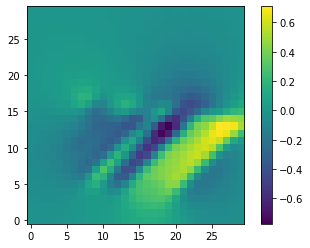

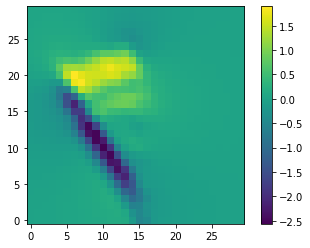

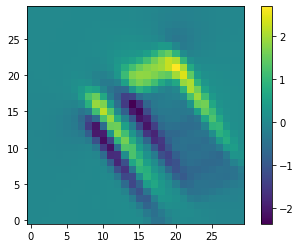

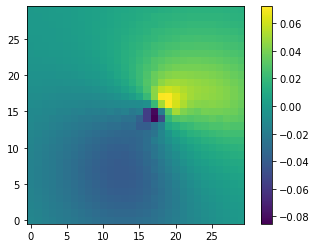

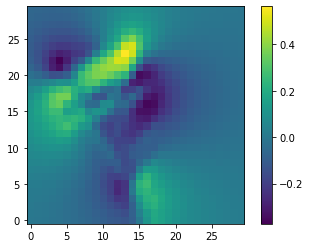

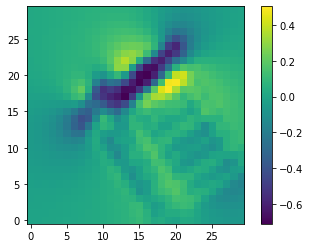

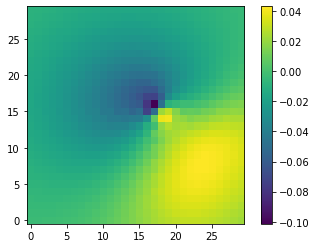

In [268]:
for i in [0,1,2]:
    for j in [0,1,2]:
        for k in [1,-1]:
            for a in [0,1,2]:
                BZ2 = -1*(np.gradient(BXc)[i]+k*np.gradient(BYc)[j])
                plt.imshow(np.sum(BZ2,axis=a).T,origin='lower')
                plt.colorbar()
                plt.show()

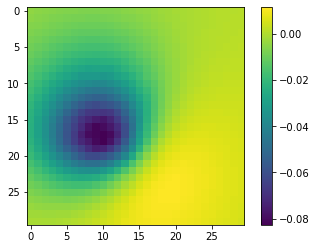

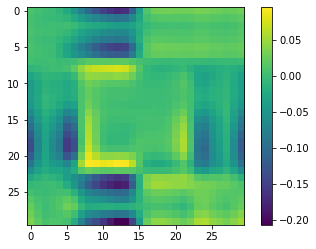

In [294]:
plt.imshow(BZ[n:-n,n:-n,n+27])
plt.colorbar()
plt.show()
plt.imshow(bz[:,:,27])#,vmin=-.5e-8,vmax=.5e-8)
plt.colorbar()

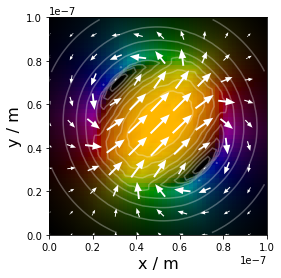

In [80]:
ma.plot_2d_B(np.sum(BX,axis=2)[n:-n,n:-n],np.sum(BY,axis=2)[n:-n,n:-n],mesh_params=mesh_params,scale=8,s=5)

In [364]:
bxp = ma.project_along_z(BX[n:-n,n:-n,n:-n],mesh_params=mesh_params)
np.max(bxp),np.max(bxproj)

(1.0470567720924307e-08, 9.0553502e-09)

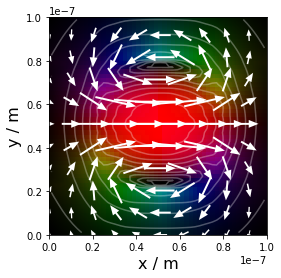

In [54]:
ma.plot_2d_B(bxproj[n:-n,n:-n],byproj[n:-n,n:-n],mesh_params=mesh_params,scale=4,s=5,quiver=True)

In [70]:
bx,by,bz=BX,BY,BZ
p1,p2,n=mesh_params
resx = p2[0]/n[0] # resolution in m per px 
resy = p2[1]/n[1] # resolution in m per px 
resz = p2[2]/n[2] # resolution in m per px 

kx = np.fft.fftfreq(bx.shape[0],d=resx)
ky = np.fft.fftfreq(bx.shape[0],d=resy)
kz = np.fft.fftfreq(bx.shape[0],d=resz)
KX, KY, KZ = np.meshgrid(kx,ky,kz, indexing='ij') # Create a grid of coordinates

KZ_inv = np.nan_to_num(((KZ+0.001*resx))**-1)
inside=-KX*KZ_inv*np.fft.fftn(bx)-KY*KZ_inv*np.fft.fftn(by)
#inside=np.fft.fftshift(inside)
bzn = np.fft.ifftn(inside).real

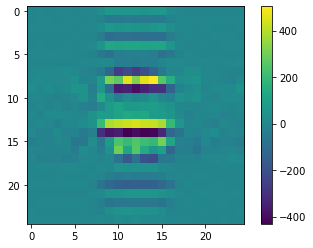

In [77]:
nn=100
plt.imshow(bzn[nn:-nn,nn:-nn,nn+14])
plt.colorbar()

Phantom error:  0.4082152794619212 COD:  0.918625886734


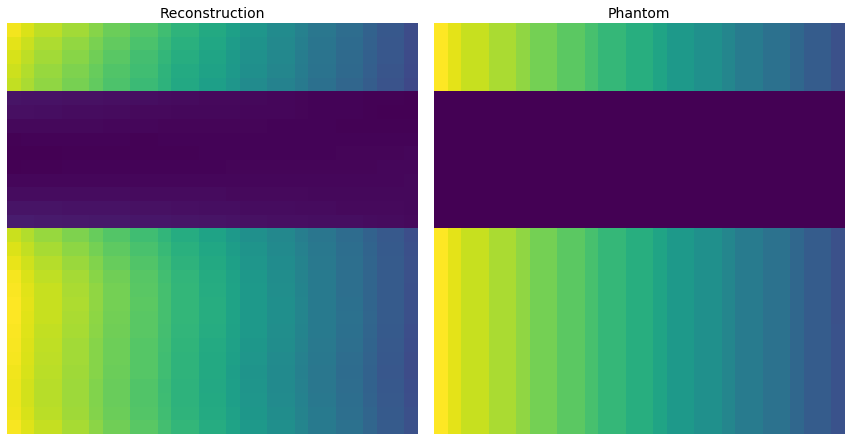

In [33]:
X,Y,Z,P = ma.generate_tri_pris(n=30)
angles = ma.generate_angles(mode='x',alpha=90,beta=90,tilt2='beta',n_tilt=13)
raw_data = ma.generate_proj_data(P,angles)
vectors = ma.generate_vectors(angles)
recon = ma.generate_reconstruction(raw_data,vectors,algorithm='SIRT3D_CUDA',niter=10,callback_freq=20,weight=0.001)
recon_vector = ma.reorient_reconstruction(recon)
ma.compare_projection(recon_vector,P,ax=90)

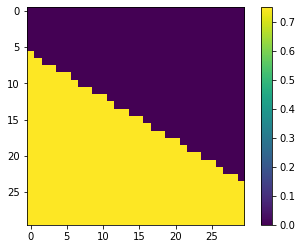

In [35]:
plt.imshow(raw_data[:,6,:])
plt.colorbar()

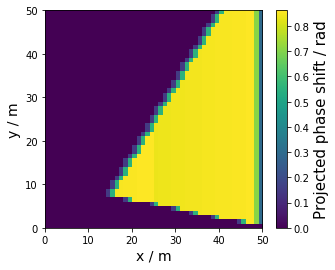

In [198]:
ma.plot_phase_proj(raw_data[:,20,:])

In [61]:
import time
angles = ma.generate_angles(mode='dual',alpha=90,beta=90,tilt2='beta',n_tilt=20)
phase_projs=[]
for i in range(len(angles)):
    ax,ay,az = angles[i]
    #rotate M
    MXr,MYr,MZr = rotate_magnetisation(MX,MY,MZ,ax,ay,az)
    #calculate phase
    phase = ma.calculate_phase_M_2D(MXr,MYr,MZr,mesh_params=mesh_params,n_pad=100)
    phase = np.flipud(phase.T)

    phase_projs.append(phase)            
    t3=time.time()
#    # Prepare projections for reconstruction
#    raw_data = np.array(M_projs)
#     raw_data = raw_data -  raw_data.min()
#     raw_data = raw_data/raw_data.max()
phase_projs = np.transpose(phase_projs,axes=[1,0,2]) # reshape so proj is middle column

phases = np.array(phase_projs)

0 31.08475685119629
1 31.407667875289917
2 31.612377882003784
3 31.8185977935791
4 32.14201831817627
5 32.34918141365051
6 32.55544137954712
7 32.76077127456665
8 33.085033893585205
9 33.29205131530762
10 33.49941110610962
11 33.70336174964905
12 33.909350872039795
13 34.231544733047485
14 34.43427515029907
15 34.64347529411316
16 34.85301685333252
17 35.1736364364624
18 35.38010287284851
19 35.58466172218323


In [68]:
p = phases-np.min(phases)
p=p/np.max(p)
vecs = ma.generate_vectors(angles)
recon = ma.generate_reconstruction(p,vecs, algorithm = 'SIRT3D_CUDA', niter=40, weight = 0.001,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

r = np.transpose(recon,axes=(2,1,0))[:,::-1,:]

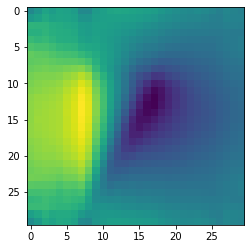

In [72]:
plt.imshow(np.sum(r[:,:,15])

In [6]:
def calculate_B_dual_2(PX,PY,mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x_size = p2[0]
    x_res = x_size/n[0]
    
    y_size = p2[1]
    y_res = y_size/n[1]
    
    BX,BY,BZ = [],[],[]
    
    resx = p2[0]/n[0] # resolution in m per px 
    resy = p2[1]/n[1] # resolution in m per px 
    resz = p2[2]/n[2] # resolution in m per px 
    
    azx= calculate_AZ_from_phase_recon(PX,mesh_params)
    azy= calculate_AZ_from_phase_recon(PY,mesh_params)
    
    BX = np.gradient(azy,resy)[1]/(2*np.pi)
    BY = -np.gradient(azx,resx)[0]/(2*np.pi)
    
#     BX = -np.gradient(azy,resy)[1]/(2*np.pi)
#     BY = np.gradient(azx,resx)[0]/(2*np.pi)
    dBZ = -1*(np.gradient(BX,resx)[0]+np.gradient(BY,resy)[1]) *resz
    
    BZ=[]
    old=0
    for i in range(np.shape(dBZ)[2]):
        dbz=dBZ[:,:,i]
        cum = dbz+old
        BZ.append(cum)
        old=cum 
    #BZ -= np.mean(BZ)
    
    
#     for i in range(np.shape(PX)[2]):
#         px = PX[:,:,i]
#         py = PY[:,:,i]
#         d_phase_x = np.gradient(px,resx)
#         d_phase_y = np.gradient(py,resy)
# #         plt.imshow(d_phase_y[1])
# #         plt.show()
#         b_const = (constants.codata.value('mag. flux quantum')/(np.pi))
#         b_field_x = -b_const*d_phase_y[1] / resx 
#         b_field_y = b_const*d_phase_x[0] / resy 
#         b_field_z = -1*(np.gradient(b_field_x,resz)[0]+np.gradient(b_field_y,resz)[1])*resz
        
#         BX.append(b_field_x)
#         BY.append(b_field_y)
#         BZ.append(b_field_z)
        
#     # somehow the axes are in the wrong order and this fixes it
#     BX = np.transpose(BX,axes=[1,2,0])
#     BY = np.transpose(BY,axes=[1,2,0])
#     BZ = np.transpose(BZ,axes=[1,2,0])
    
    return np.array(BX),np.array(BY),np.array(BZ)

In [14]:
bx2,by2,bz2 = calculate_B_dual_2(rx,ry,mesh_params=mesh_params)

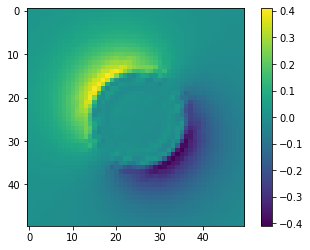

In [75]:
n=100
plt.imshow(BZ[n:-n,n:-n,n+15].T)
plt.colorbar()

In [17]:
ma.COD(bx2[n:-n,n:-n,n:-n],BX[n:-n,n:-n,n:-n]),ma.COD(by2[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n]),ma.COD(bz2[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n])

(0.48053241465560198, 0.48053250804114123, 0.058316494642764304)

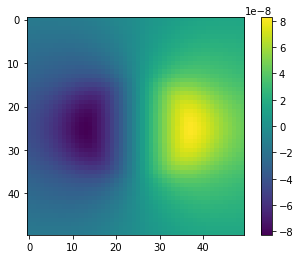

In [281]:
azx= calculate_AZ_from_phase_recon(rx,mesh_params)
plt.imshow(azx[:,:,n+15][n:-n,n:-n])
plt.colorbar()

(0.72093139583075305, -0.2909248871783891, 1.0118562830091422)

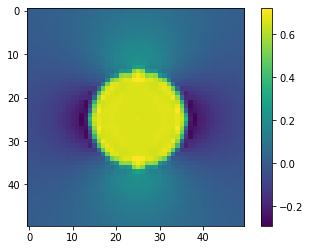

In [285]:
a=BX#-bx2
b= a[:,:,n+15][n:-n,n:-n]
#plt.imshow( ((a[:,:,n+25] - np.min(a[:,:,n+25])) /np.max(a[:,:,n+25]-np.min(a[:,:,n+25])))[n:-n,n:-n] )
plt.imshow(b)
plt.colorbar()
np.max(b),np.min(b),np.max(b)-np.min(b)

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  after removing the cwd from sys.path.


ValueError: total size of new array must be unchanged

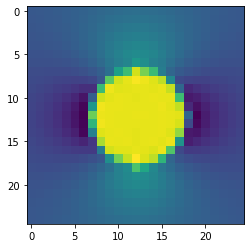

In [305]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

s=np.array(np.shape(b))/2
blur = rebin(b,s)
plt.imshow(blur)
deblur = rebin(blur,np.shape(b))

In [4]:
MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.sphere(bbox_length_px=50,rad_m=3e-8,plan_rot=45)
# A 3d
AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=100)
# B 3d
BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)

In [5]:
angles_x = ma.generate_angles(mode='x',n_tilt=90,alpha=90)
angles_y = ma.generate_angles(mode='y',n_tilt=90,beta=90,tilt2='beta')
phases_x = generate_phase_data(MX,MY,MZ,angles_x,mesh_params=mesh_params,n_pad=100,unpad=False)
phases_y = generate_phase_data(MX,MY,MZ,angles_y,mesh_params=mesh_params,n_pad=100,unpad=False)

In [6]:
# calculate B before reconstruction
ps = np.transpose(phases_y,axes=[1,0,2])
bxs = []
for p in ps:
    _,bx,_ = ma.calculate_B_from_phase(p,mesh_params=mesh_params2)
    bxs.append(bx)
    
ps = np.transpose(phases_x,axes=[1,0,2])
bys = []
for p in ps:
    _,_,by = ma.calculate_B_from_phase(p,mesh_params=mesh_params2)
    bys.append(by)
    
bxs = np.transpose(bxs,axes=[1,0,2])
bys = np.transpose(bys,axes=[1,0,2])

In [20]:
np.shape(bxs)

(250, 90, 250)

In [ ]:
vecs = ma.generate_vectors(angles_x)
recon_x = ma.generate_reconstruction(phases_x,vecs, algorithm = 'SIRT3D_CUDA', niter=100, weight = 0.001,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

vecs = ma.generate_vectors(angles_y)
recon_y = ma.generate_reconstruction(phases_y,vecs, algorithm = 'SIRT3D_CUDA', niter=100, weight = 0.01,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

In [ ]:
rx = np.transpose(recon_x,axes=(2,1,0))[:,::-1,:]
ry = np.transpose(recon_y,axes=(2,1,0))[:,::-1,:]

In [7]:
vecs = ma.generate_vectors(angles_x)
bx3 = ma.generate_reconstruction(bxs,vecs, algorithm = 'SIRT3D_CUDA', niter=100, weight = 0.001,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

vecs = ma.generate_vectors(angles_y)
by3 = ma.generate_reconstruction(bys,vecs, algorithm = 'SIRT3D_CUDA', niter=100, weight = 0.01,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

bx3 = np.transpose(bx3,axes=(2,1,0))[:,::-1,:]
by3 = np.transpose(by3,axes=(2,1,0))[:,::-1,:]

In [8]:
p1,p2,n=mesh_params2
resx=p2[0]/n[0]
resy=p2[1]/n[1]

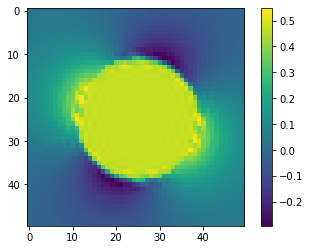

In [19]:
n=100
#plt.imshow(-by3[n:-n,n:-n,100+20].T/resx)
plt.imshow(BY[n:-n,n:-n,100+20])
plt.colorbar()

In [9]:
bx,by,bz = calculate_B_dual(rx,ry,mesh_params=mesh_params)

NameError: name 'calculate_B_dual' is not defined

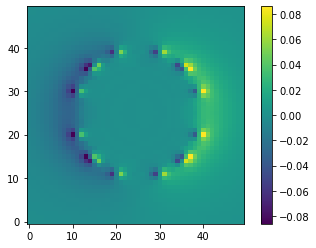

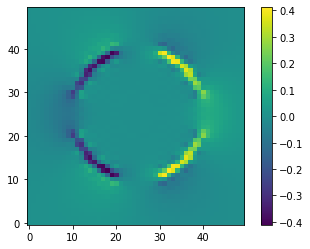

In [10]:
n=100
BXc = BX[n:-n,n:-n,n:-n]
BYc = BY[n:-n,n:-n,n:-n]
BZc = BZ[n:-n,n:-n,n:-n]

i=25

BZc = BZ[n:-n,n:-n,n:-n]
#plt.imshow(BZ[n:-n,n:-n,i+n].T,origin='lower')
plt.imshow(np.gradient(BZ)[2][n:-n,n:-n,i+n].T,origin='lower')
plt.colorbar()
plt.show()

# p1,p2,n=mesh_params
# resx=p2[0]/n[0]
# resy=p2[1]/n[1]
# print(resx,resy)
BZ2 = -1*(np.gradient(BX)[0]-np.gradient(BY)[1])
plt.imshow(BZ2[n:-n,n:-n,n+i].T,origin='lower')
plt.colorbar()

Text(0.5, 0, 'Z / px')

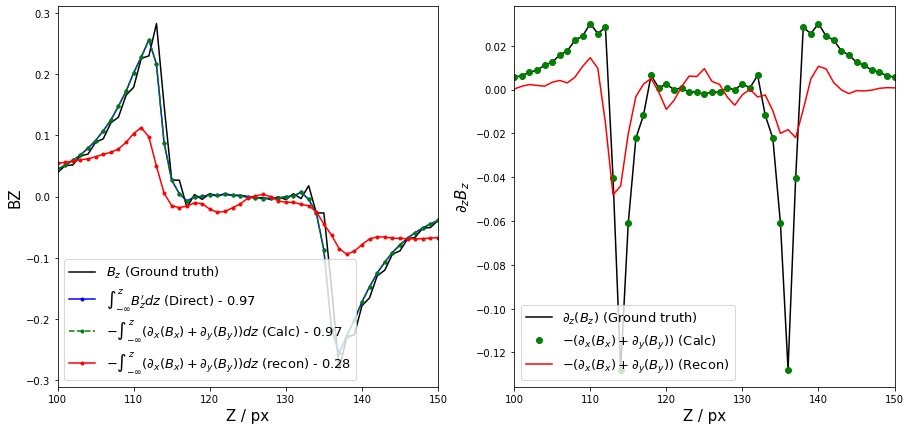

In [115]:
f,axs=plt.subplots(ncols=2,figsize=(15,7))

# BZ direct
y=BZ[n+15,n+25,:].T
axs[0].plot(y,'k',label='$B_z$ (Ground truth)')

# dBZ direct
dy = np.gradient(BZ[n+15,n+25,:].T)
axs[1].plot(dy,'k',label='$\partial_z (B_z)$ (Ground truth)')

# iBZ (direct)
yi = []
old=0
for dyi in dy:
    cum = dyi+old
    yi.append(cum)
    old=cum    

cod = ma.COD(y,yi)    
axs[0].plot(yi,'b.-',label='$\int_{-\infty}^z B_z\' dz$ (Direct) - %.2f' % cod)

# dBz direct from bx,by
dy_calc = -1*(np.gradient(BX)[0]+np.gradient(BY)[1])[n+15,n+25,:].T
axs[1].plot(dy_calc,'go',label='$-(\partial_x (B_x)+\partial_y (B_y))$ (Calc)')

# BZ calc from bx,by
yi_calc = []
old=0
for dyi in dy_calc:
    cum = dyi+old
    yi_calc.append(cum)
    old=cum    
yi_calc -= np.mean(yi_calc)

cod = ma.COD(y,yi_calc) 
axs[0].plot(yi_calc,'g.--',label='$-\int_{-\infty}^z (\partial_x (B_x)+\partial_y (B_y)) dz$ (Calc) - %.2f' % cod)

# dBZ from bx,by reconstructed
#dy_recon = 1*(np.gradient(bx2)[0]+np.gradient(by2)[1])[n+15,n+25,:].T
dy_recon = -1*(-np.gradient(bx3)[0]+np.pi*np.gradient(by3)[1])[n+15,n+25,:].T/resx
axs[1].plot(dy_recon,'r',label='$-(\partial_x (B_x)+\partial_y (B_y))$ (Recon)')

# BZ from bx, by reconstructed
yi_recon = []
old=0
for dyi in dy_recon:
    cum = dyi+old
    yi_recon.append(cum)
    old=cum 
yi_recon -= np.mean(yi_recon)
cod = ma.COD(y,yi_recon) 
axs[0].plot(yi_recon,'r.-',label='$-\int_{-\infty}^z (\partial_x (B_x)+\partial_y (B_y)) dz$ (recon) - %.2f' % cod)
    
axs[0].set_xlim([100,150])
axs[1].set_xlim([100,150])
axs[0].legend(fontsize=13,loc='lower left')
axs[1].legend(fontsize=13)

axs[0].set_ylabel('BZ',fontsize=15)
axs[0].set_xlabel('Z / px',fontsize=15)

axs[1].set_ylabel(r'$\partial_z B_z$',fontsize=15)
axs[1].set_xlabel('Z / px',fontsize=15)

(100, 150)

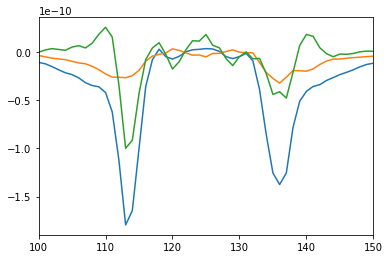

In [112]:
a = []
for i,x in enumerate(dy):
    if i == 0 or i == len(dy)-1:
        a.append(x)
    else:
        a.append((dy[i-1]+dy[i+1])/2)
#plt.plot(dy)
#plt.plot(a)
dy_calc = -1*(np.gradient(BX)[0]+np.gradient(BY)[1])[n+15,n+25,:].T
#plt.plot(dy_calc)
# plt.plot(bx2[n+15,n+25,:].T)
# plt.plot(BX[n+15,n+25,:].T)
plt.plot((np.gradient(bx3)[0])[n+15,n+25,:].T)
plt.plot((np.gradient(by3)[1])[n+15,n+25,:].T)
plt.plot(1*(-3*np.gradient(by3)[1])[n+15,n+25,:].T+1*(np.gradient(bx3)[0])[n+15,n+25,:].T)
plt.xlim([100,150])

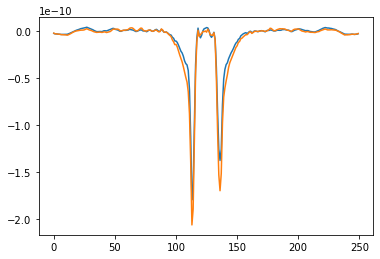

In [38]:
plt.plot(np.gradient(bx3)[0][n+15,n+25,:].T)
plt.plot(np.gradient(bx3)[0][n+15,n+25,:].T+np.gradient(by3)[1][n+15,n+25,:].T)

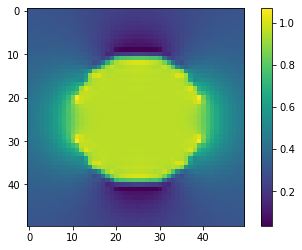

In [42]:
plt.imshow(BX[n:-n,n:-n,125].T-np.min(BX))
plt.colorbar()

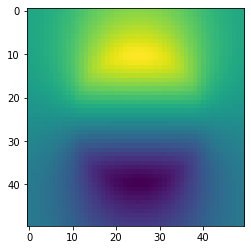

In [33]:
plt.imshow(rx[n:-n,n:-n,125].T)

In [306]:
i=35
ma.COD(bz2[n:-n,n:-n,n+i],BZ[n:-n,n:-n,i+n])

0.050406894938894047

In [309]:
ma.COD(by2[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n])

0.90296147621968115

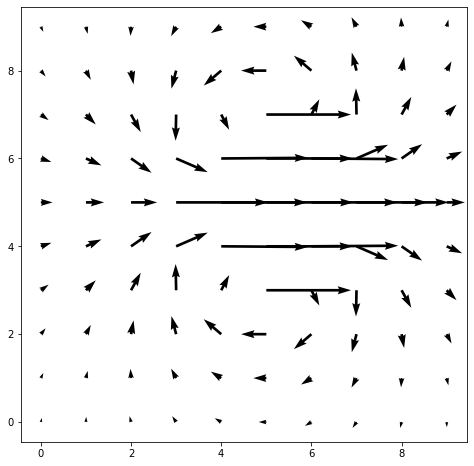

In [111]:
a=BX[n:-n,n:-n]
b=BY[n:-n,n:-n]
plt.figure(figsize=(8,8))
plt.quiver(a[::5,::5,i+n].T,b[::5,::5,i+n].T,)

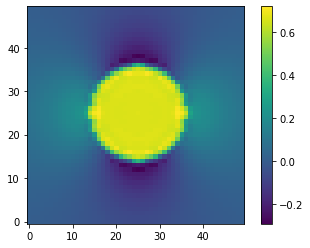

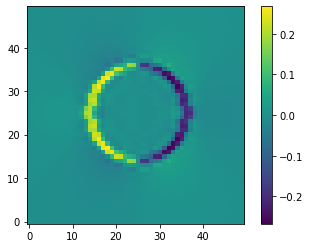

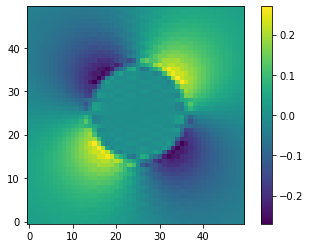

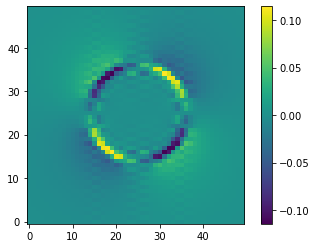

In [72]:
i=35
plt.imshow(BX[n:-n,n:-n,i+n].T,origin='lower')
plt.colorbar()
plt.show()
plt.imshow(np.gradient(BX)[0][n:-n,n:-n,i+n].T,origin='lower')
plt.colorbar()
plt.show()

plt.imshow(BY[n:-n,n:-n,i+n].T,origin='lower')
#plt.imshow(,origin='lower')
plt.colorbar()
plt.show()
plt.imshow(np.gradient(BY)[2][n:-n,n:-n,i+n].T,origin='lower')
plt.colorbar()

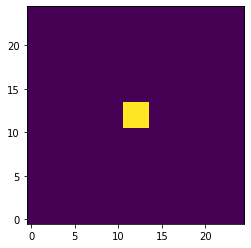

In [420]:
bm = np.hypot(MX,MY)
plt.imshow(bm[:,:,14].T,origin='lower')

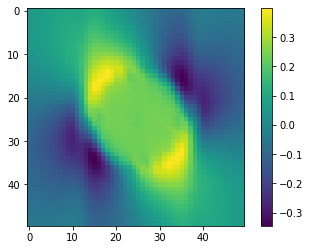

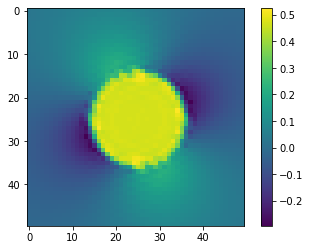

In [29]:
plt.imshow(bx2[n:-n,n:-n,n+15])
plt.colorbar()
plt.show()

plt.imshow(BX[n:-n,n:-n,n+15])#+BY[n:-n,n:-n,n+15]+BZ[n:-n,n:-n,n+15])
plt.colorbar()
plt.show()

In [9]:
def plot_3d_B_slice(bx,by,bz,i_slice=None,mesh_params=None, ax=None,s=5,scale=7,mag_res=0.1, quiver=True, cbar=False,B_contour=True,phase=None,phase_res=np.pi/50):
    """ Plot projected B field
    quiver = turn on/off the arrows
    s = quiver density
    scale = quiver arrow size
    B_contour = turn on/off |B| contour lines
    mag_res = spacing of |B| contour lines in T
    phase = pass phase shifts to plot phase contours
    phase_res = spacing of phase contours in radians
    """
    if ax == None:
        fig,ax = plt.subplots()
    
    if mesh_params == None:
        p1 = (0,0,0)
        sh = np.shape(bx)
        p2 = (sh[0],sh[1],sh[0])
        n = p2
        mesh_params = [p1,p2,n]
        
    if type(i_slice) is type(None):
        i_slice=int(np.shape(bz)[2]/2)
        
    bx=copy.deepcopy(bx)
    by=copy.deepcopy(by)
    bz=copy.deepcopy(bz)
        
    bmax = np.max((bx**2+by**2+bz**2)**0.5)
    mag_B = ((bx**2+by**2)**0.5)[:,:,i_slice]
    bx=bx[:,:,i_slice]
    by=by[:,:,i_slice]
    bz=bz[:,:,i_slice]
        
    
    p1,p2,n = mesh_params
    mag_B = np.hypot(bx,by)

    

    # plot BZ a colour
    # using tan-1(vy/vx)
    im=ax.imshow(bz.T,origin='lower', 
               extent=[p1[0], p2[0], p1[1],p2[1]], cmap='RdBu',vmin=-bmax,vmax=bmax)
    if cbar==True:
        fig=plt.gcf()
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.7])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('$B_z$ / T', rotation=-270,fontsize=15)

    # Plot magnitude of B as in black/transparent scale
    # Create alpha contour map
    my_cmap = ma.alpha_cmap()
    ax.imshow(mag_B.T,origin='lower', 
               extent=[p1[0], p2[0], p1[1],p2[1]],interpolation='spline16', cmap=my_cmap,alpha=1,vmin=0,vmax=bmax)

    ax.set_xlabel('x / m', fontsize = 16)
    ax.set_ylabel('y / m', fontsize = 16)
    
    # Quiver plot of Bx,By
    if quiver==True:
        x = np.linspace(p1[0],p2[0],num=n[0])
        y = np.linspace(p1[1],p2[1],num=n[1])
        xs,ys = np.meshgrid(x,y)
        ax.quiver(xs[::s,::s],ys[::s,::s],bx[::s,::s].T,by[::s,::s].T,color='white',scale=bmax*scale,
                  pivot='mid',width=0.013,headaxislength=5,headwidth=4,minshaft=1.8,edgecolors='k',lw=.3)
        
    
    # Contour plot of |B|
    if B_contour==True:
        mag_range = 2*np.max(mag_B)
        n_levels = int(mag_range/mag_res)
        cs = ax.contour(mag_B.T,origin='lower',levels=n_levels, extent=[p1[0], p2[0], p1[1],p2[1]], alpha = .3,colors='white')
        
    # Contour plot of phase
    if type(phase)!=type(None):
        phase_range = (np.max(phase)-np.min(phase))/1e-9
        n_levels = int(phase_range/phase_res)
        cs = ax.contour(phase.T-np.min(phase).T,origin='lower',levels=10, extent=[p1[0], p2[0], p1[1],p2[1]], alpha = .3,colors='white')
    
    ax.axis('off')

In [10]:
def plot_B_series(bx,by,bz,slices=None):
    fig,axs=plt.subplots(ncols=len(slices),figsize=(15,3))
    for i,i_slice in enumerate(slices):
        if i == len(slices)-1:
            plot_3d_B_slice(bx,by,bz,ax=axs[i],i_slice=i_slice,cbar=True)
        else:
            plot_3d_B_slice(bx,by,bz,ax=axs[i],i_slice=i_slice)
        
    plt.tight_layout()

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


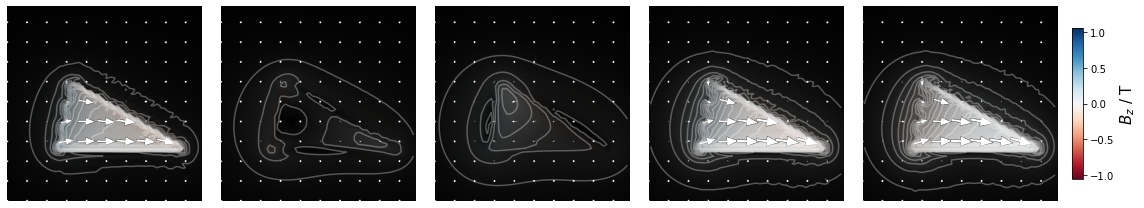

In [14]:
plot_B_series(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],slices=[16,20,24,28,34])

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


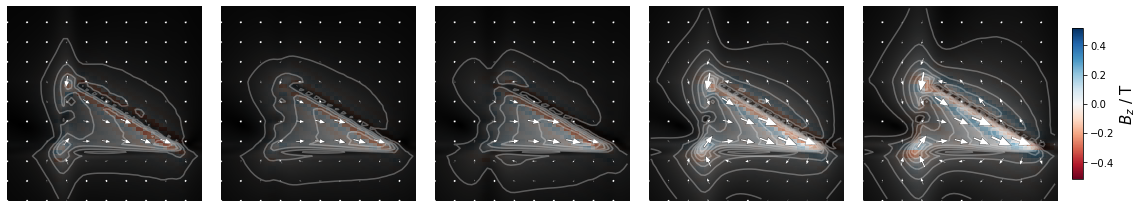

In [15]:
plot_B_series(bx_recon[n:-n,n:-n,n:-n],by_recon[n:-n,n:-n,n:-n],bz_recon[n:-n,n:-n,n:-n],slices=[16,20,24,28,34])

0.0650421452078
0.0650421452078
0.0650421452078
4


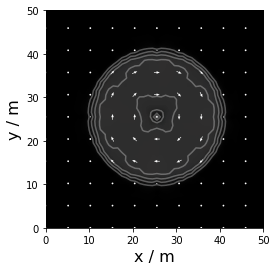

In [286]:
n=100
plot_3d_B_slice(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],i_slice=30)

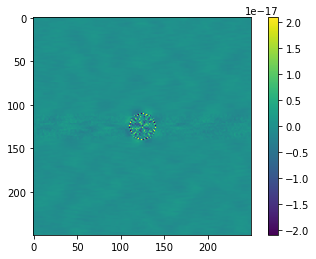

In [250]:
plt.imshow(BZ[:,:,n+25])
plt.colorbar()

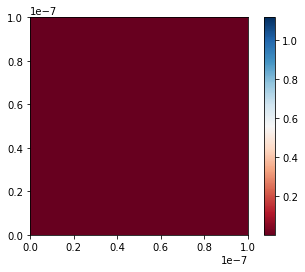

In [191]:
plt.imshow(BZ[:,:,75].T,origin='lower', 
               extent=[p1[0], p2[0], p1[1],p2[1]], cmap='RdBu',vmin=np.min(mag_B),vmax=np.max(mag_B))

plt.colorbar()

In [16]:
from pyevtk.hl import gridToVTK


In [17]:
import pyevtk

In [19]:
dim = BX.shape
x = np.arange(dim[0])
y = np.arange(dim[1])
z = np.arange(dim[2])
X,Y,Z = np.meshgrid(x,y,z,indexing='ij')
xf = np.reshape(X,dim[0]*dim[1]*dim[2])
yf = np.reshape(Y,dim[0]*dim[1]*dim[2])
zf = np.reshape(Z,dim[0]*dim[1]*dim[2])

bxf = copy.deepcopy(BX)
byf = copy.deepcopy(BY)
bzf = copy.deepcopy(BZ)
bxf = np.reshape(bxf,dim[0]*dim[1]*dim[2])
byf = np.reshape(byf,dim[0]*dim[1]*dim[2])
bzf = np.reshape(bzf,dim[0]*dim[1]*dim[2])

vec = [bxf,byf,bzf]
np.shape(vec)


(3, 15625000)

In [95]:
vec = {'u':bxf,'v':byf,'w':bzf}

In [20]:
pyevtk.hl.gridToVTK('sphere_true',X,Y,Z,pointData={'u':BX,'v':BY,'w':BZ})

'/home/grl31/Documents/GitHub/phd-work/multi-axis-tomo/sphere_true.vts'

In [133]:
bx2 = np.ascontiguousarray(bx_recon)

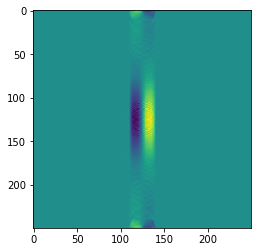

In [132]:
plt.imshow(bx_recon[:,:,75])

In [128]:
bx2.flags['C_CONTIGUOUS']

True

In [21]:
pyevtk.hl.gridToVTK('sphere_recon',X,Y,Z,pointData={'u':np.ascontiguousarray(bx_recon),'v':np.ascontiguousarray(by_recon),'w':np.ascontiguousarray(bz_recon)})

'/home/grl31/Documents/GitHub/phd-work/multi-axis-tomo/sphere_recon.vts'

In [ ]:
def save_B_to_paraview(fpath,bx,by,bz):
    """ Export B arrays to .vts paraview file
      
    Once in paraview:
    * apply python calculator, in expression put 'make_vector(u,v,w)'
    * extract subset to desired size
    * for streamtracer, apply filter or press button. in colorbar select enable opacity to hide small magnitude. use pointcloud seeds for better result
    * for arrows, apply glyph filter, make sure orientation is 'result'

    """
    
    dim = bx.shape
    x = np.arange(dim[0])
    y = np.arange(dim[1])
    z = np.arange(dim[2])
    X,Y,Z = np.meshgrid(x,y,z,indexing='ij')
    
    gridToVTK(fpath,X,Y,Z,pointData={'u':np.ascontiguousarray(bx),'v':np.ascontiguousarray(by),'w':np.ascontiguousarray(bz)})

In [79]:
from tvtk.api import tvtk, write_data

ImportError: No module named 'vtkIOExodusPython'
________________________________________________________________________________
Do you have vtk installed properly?
VTK (and build instructions) can be obtained from http://www.vtk.org


In [5]:
import sys



# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mems = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
mems

[('bx_recon', 62500128),
 ('by_recon', 62500128),
 ('as_x', 928),
 ('as_y', 928),
 ('CC', 136),
 ('MAAPE', 136),
 ('NRMSE', 136),
 ('coor_to_grid', 136),
 ('dual_axis_B_generation', 136),
 ('dual_axis_bz_from_bxby', 136),
 ('dual_axis_phase_generation', 136),
 ('dual_axis_reconstruction', 136),
 ('generate_phase_data', 136),
 ('gridToVTK', 136),
 ('grid_to_coor', 136),
 ('plot_3d_B_slice', 136),
 ('rotate_magnetisation', 136),
 ('rotate_vector', 136),
 ('save_B_to_paraview', 136),
 ('test_metric', 136),
 ('BX', 128),
 ('BY', 128),
 ('BZ', 128),
 ('bxs', 128),
 ('bys', 128),
 ('mesh_params', 112),
 ('mesh_params2', 112),
 ('constants', 80),
 ('ma', 80),
 ('ndimage', 80),
 ('np', 80),
 ('patches', 80),
 ('plt', 80),
 ('n', 28),
 ('n_iter', 28)]

In [6]:
vals = np.array(mems)[:,1]
tot = np.sum(vals.astype('float32'))

In [7]:
tot/1e6

125.005696